# Joint data analysis

This will be the notebook in which I will conduct my joint data analysis.
The idea is that I can use my JOD data as well as my quantitative data from the cluster in order to formulate some joint statements about my model performance.


In [1]:
import pandas as pd

df_jod = pd.read_excel("data/jod.xlsx")
df_metrics = pd.read_excel("data/singleMetricsResult.xlsx")

In [2]:
df_jod.round(3).to_latex()

'\\begin{tabular}{lrllrrrrrrr}\n\\toprule\n & Unnamed: 0 & size & dataset & default & mcmc & mini_splatting & eagles & mip_splatting & gaussian_pro & geo_gaussian \\\\\n\\midrule\n0 & 0 & low & room & 1.225000 & 0.043000 & 0.009000 & -0.936000 & 0.504000 & -0.176000 & -0.669000 \\\\\n1 & 1 & low & stump & 0.085000 & 1.091000 & 0.589000 & -1.131000 & 0.847000 & 0.148000 & -1.628000 \\\\\n2 & 2 & low & truck & 1.508000 & 3.304000 & -0.125000 & -0.201000 & -7.268000 & 0.304000 & 2.477000 \\\\\n3 & 3 & medium & room & -2.427000 & -4.120000 & -5.309000 & 5.985000 & 4.415000 & 4.969000 & -3.514000 \\\\\n4 & 4 & medium & stump & -5.231000 & 10.146000 & 11.993000 & -6.914000 & 2.800000 & -6.086000 & -6.709000 \\\\\n5 & 5 & medium & truck & -1.900000 & 6.334000 & -2.351000 & -1.588000 & 5.380000 & -3.194000 & -2.682000 \\\\\n6 & 6 & high & room & -0.216000 & -1.400000 & 0.445000 & 1.378000 & 0.891000 & 0.776000 & -1.874000 \\\\\n7 & 7 & high & stump & -0.113000 & 1.347000 & 3.049000 & 1.453000 

In [4]:
rename_metrics = {
    "default": "Default",
    "eagles": "EAGLES",
    "gaussian-pro": "Gaussian-Pro",
    "geo-gaussian": "Geo-Gaussian",
    "mcmc": "MCMC",
    "mini-splatting": "Mini-Splatting",
    "mip-splatting": "Mip-Splatting",
}

df_metrics["model"] = df_metrics["model"].apply(lambda x: rename_metrics[x])

In [5]:
rename_jod = {
    "default": "Default",
    "mcmc": "MCMC",
    "mini_splatting": "Mini-Splatting",
    "eagles": "EAGLES",
    "mip_splatting": "Mip-Splatting",
    "gaussian_pro": "Gaussian-Pro",
    "geo_gaussian": "Geo-Gaussian",
}

df_jod = df_jod.rename(rename_jod, axis=1)

## Objective Ranking


### Lineplots - What is the objective ranking per facet of the data?


In [6]:
from matplotlib import pyplot as plt
import numpy as np


def bootstrap_std(data, n_boot=10000):
    boot_samples = np.random.choice(data, (n_boot, len(data)), replace=True)
    return np.std(boot_samples, axis=1).mean()  # Mean of bootstrapped stds


def contrast_ranking_by_size(dataset: str) -> None:
    fig, axs = plt.subplots(2, 2, figsize=(18, 10))
    handles, labels = [], []

    for i, metric in enumerate(["psnr", "ssim", "lpips", "brisque"]):
        df_constrained = df_metrics[df_metrics["dataset"] == dataset]
        for model in df_constrained["model"].unique():
            if metric == "brisque":
                sub_df = (
                    (
                        df_constrained[df_constrained["model"] == model][
                            [
                                "size",
                                "brisque",
                                "brisque_0",
                                "brisque_1",
                                "brisque_2",
                                "brisque_3",
                                "brisque_4",
                            ]
                        ]
                        .melt(id_vars="size")
                        .rename({"value": "brisque"}, axis=1)
                    )
                    .groupby(["size"], sort=False, as_index=False)[["brisque"]]
                    .agg(["mean", bootstrap_std, "count"])
                )
            else:
                sub_df = (
                    df_constrained[df_constrained["model"] == model]
                    .groupby(["size"], sort=False, as_index=False)[[metric]]
                    .agg(["mean", bootstrap_std, "count"])
                )

            y_vals = sub_df[metric, "mean"]
            ci_1 = (
                sub_df[metric, "bootstrap_std"] / np.sqrt(sub_df[metric, "count"]) * 1
            )

            current_handles = axs[i % 2][int(i / 2)].plot(
                ["low", "medium", "high"], y_vals
            )

            if i == 0:
                handles.extend(current_handles)
                labels.append(model)

            axs[i % 2][int(i / 2)].fill_between(
                ["low", "medium", "high"],
                y_vals - ci_1,
                y_vals + ci_1,
                alpha=0.6,
                color="#d6d6d6",
            )
            axs[i % 2][int(i / 2)].set_ylabel(metric)

    fig.legend(handles, labels, loc="center left", bbox_to_anchor=(1.0, 0.5))
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.suptitle(f"{dataset} dataset metrics (grey = 1 standard dev)")
    plt.show()


# contrast_ranking_by_size("room")

In [7]:
# contrast_ranking_by_size("stump")

In [8]:
# contrast_ranking_by_size("truck")

### Violinplot - facet by facet ranking


In [9]:
hue_order = [
    "MCMC",
    "Mini-Splatting",
    "Gaussian-Pro",
    "Mip-Splatting",
    "EAGLES",
    "Default",
    "Geo-Gaussian",
]

In [10]:
import seaborn as sns


def plot_facet_ranking_as_violin_plot(
    dataset: str, size: str, ax: plt.Axes, metric="psnr"
) -> None:
    subset = df_metrics[
        (df_metrics["dataset"] == dataset) & (df_metrics["size"] == size)
    ]
    boot_samples_idx = np.random.choice(subset.index, (1000, len(subset)), replace=True)

    means = []
    for sample_idx in boot_samples_idx:
        means.append(
            subset.loc[sample_idx].groupby("model")[metric].mean().reset_index()
        )

    means_df = pd.concat(means)
    sns.violinplot(
        means_df,
        x="model",
        y=metric,
        hue_order=hue_order,
        hue="model",
        order=means_df.groupby("model")[metric]
        .mean()
        .sort_values(ascending=False)
        .index,
        ax=ax,
    )
    ax.set_title(
        f"Bootstrapped ranking by {metric.upper()} for {dataset} - {size}",
        fontdict={"size": 18},
    )
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontdict={"size": 14})


# fig, axs = plt.subplots(3, 3, figsize=(12, 12))

# for i, dataset in enumerate(df_metrics["dataset"].unique()):
#     for j, size in enumerate(df_metrics["size"].unique()):
#         plot_facet_ranking_as_violin_plot(dataset, size, ax=axs[i][j], metric="ssim")
# plt.tight_layout()

### Violinplot - Single Facet examples


/tmp/ipykernel_6190/1385640294.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontdict={"size": 14})


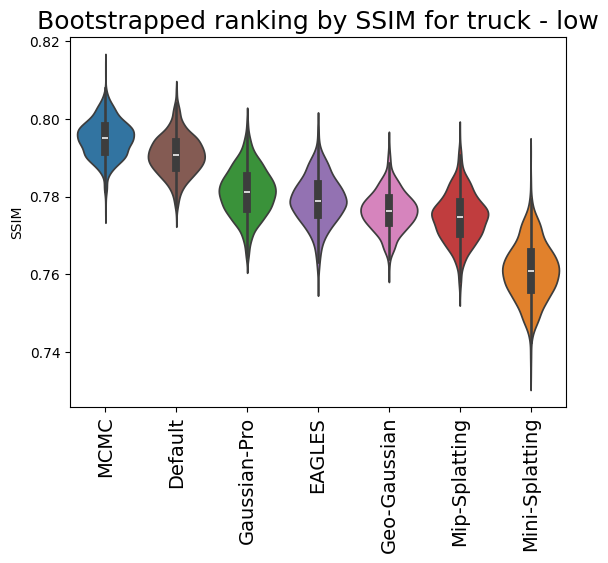

In [11]:
fig = plt.subplot()
plot_facet_ranking_as_violin_plot("truck", "low", ax=fig, metric="ssim")
plt.ylabel("SSIM")
plt.xlabel("")
plt.savefig(
    "/home/paul/TUWien/MasterThesisNerf/thesis-document/graphics/results/objective/truck-low-ssim-ranking.png",
    bbox_inches="tight",
    pad_inches=0.1,
)

/tmp/ipykernel_6190/1385640294.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontdict={"size": 14})


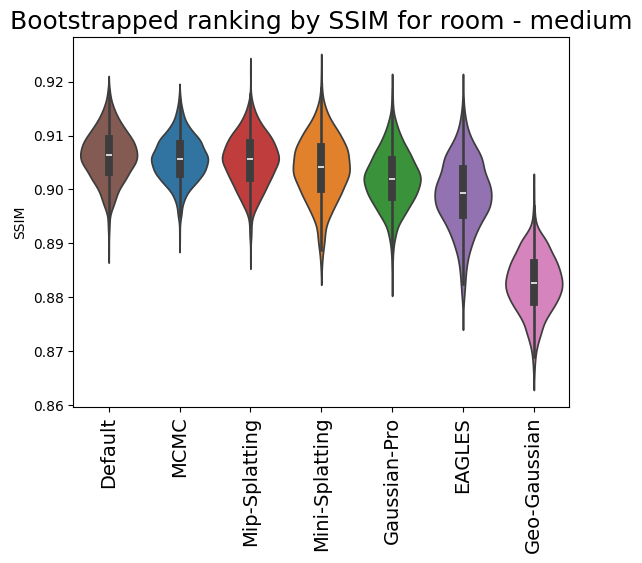

In [12]:
fig = plt.subplot()
plot_facet_ranking_as_violin_plot("room", "medium", ax=fig, metric="ssim")
plt.ylabel("SSIM")
plt.xlabel("")
plt.show()

/tmp/ipykernel_6190/1385640294.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontdict={"size": 14})


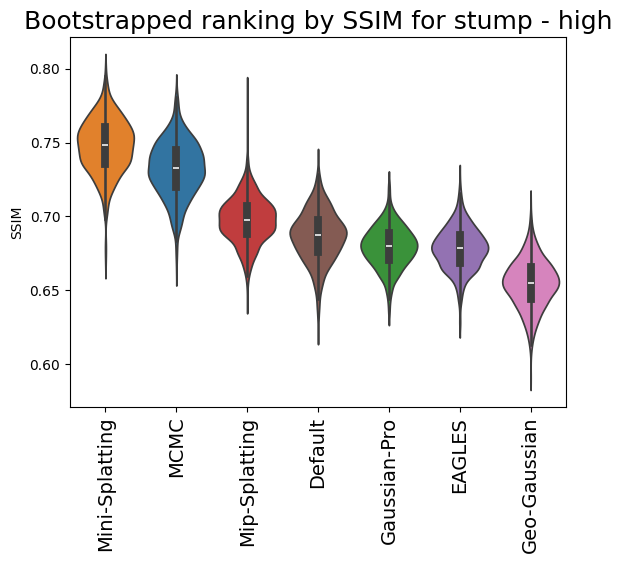

In [13]:
fig = plt.subplot()
plot_facet_ranking_as_violin_plot("stump", "high", ax=fig, metric="ssim")
plt.ylabel("SSIM")
plt.xlabel("")
plt.savefig(
    "/home/paul/TUWien/MasterThesisNerf/thesis-document/graphics/results/objective/stump-high-ssim-ranking.png",
    bbox_inches="tight",
    pad_inches=0.1,
)

### Heatmap - Facet by Facet distance matrix


In [14]:
import seaborn as sns
import itertools
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt


def compute_average_agreement(agreement_matrix):
    """
    Computes the average agreement score from the agreement matrix,
    excluding the diagonal.
    """
    # Convert to NumPy array (if not already)
    matrix_values = agreement_matrix.to_numpy()

    # Extract upper triangle values (excluding diagonal)
    upper_triangle_values = matrix_values[np.triu_indices_from(matrix_values, k=1)]

    # Compute and return the mean
    return np.mean(upper_triangle_values)


def compute_agreement_matrix(metric="psnr"):
    # Extract unique circumstances
    unique_datasets = df_metrics["dataset"].unique()
    unique_sizes = df_metrics["size"].unique()
    circumstances = list(itertools.product(unique_datasets, unique_sizes))

    # Initialize an empty 9x9 matrix
    n = len(circumstances)
    agreement_matrix = np.zeros((n, n), dtype=np.double)

    for i, (dataset1, size1) in enumerate(circumstances):
        for j, (dataset2, size2) in enumerate(circumstances):
            if i == j:
                agreement_matrix[i, j] = 1.0  # Perfect agreement with itself
                continue

            # Get rankings for each circumstance
            subset1 = df_metrics[
                (df_metrics["dataset"] == dataset1) & (df_metrics["size"] == size1)
            ]
            subset2 = df_metrics[
                (df_metrics["dataset"] == dataset2) & (df_metrics["size"] == size2)
            ]

            # Compute mean metric values per model
            if metric != "brisque":
                mean1 = subset1.groupby("model")[metric].mean()
                mean2 = subset2.groupby("model")[metric].mean()
            else:
                mean1 = (
                    (
                        subset1[
                            [
                                "model",
                                "brisque",
                                "brisque_0",
                                "brisque_1",
                                "brisque_2",
                                "brisque_3",
                                "brisque_4",
                            ]
                        ]
                        .melt(id_vars="model")
                        .rename({"value": "brisque"}, axis=1)
                    )
                    .groupby("model")[metric]
                    .mean()
                )
                mean2 = (
                    (
                        subset2[
                            [
                                "model",
                                "brisque",
                                "brisque_0",
                                "brisque_1",
                                "brisque_2",
                                "brisque_3",
                                "brisque_4",
                            ]
                        ]
                        .melt(id_vars="model")
                        .rename({"value": "brisque"}, axis=1)
                    )
                    .groupby("model")[metric]
                    .mean()
                )

            # Merge rankings on common models
            common_models = mean1.index.intersection(mean2.index)
            if len(common_models) == 0:
                agreement_matrix[i, j] = np.nan  # No common models, no correlation
                continue

            ranks1 = mean1.loc[common_models]
            ranks2 = mean2.loc[common_models]

            # Compute Spearman's Rank Correlation Coefficient (SROCC)
            srocc, _ = stats.spearmanr(ranks1, ranks2)
            agreement_matrix[i, j] = srocc

    # Convert to DataFrame for plotting
    agreement_df = pd.DataFrame(
        agreement_matrix, index=circumstances, columns=circumstances
    )

    return agreement_df
    # # Plot heatmap
    # plt.figure(figsize=(10, 8))
    # sns.heatmap(agreement_df, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
    # plt.title(f"Agreement Matrix based on {metric.upper()} with average SROCC of {compute_average_agreement(agreement_df):.3f}")
    # plt.xticks(rotation=45, ha="right")
    # plt.yticks(rotation=0)
    # plt.show()

In [15]:
import seaborn as sns
import itertools
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt


def plot_heatmaps(metrics):
    fig, axes = plt.subplots(2, 1, figsize=(7, 12), constrained_layout=True)

    # Compute agreement matrices and get min/max values for consistent color scaling
    agreement_matrices = []
    vmin, vmax = float("inf"), float("-inf")

    for metric in metrics:
        agreement_df = compute_agreement_matrix(metric)
        agreement_matrices.append(agreement_df)
        vmin = min(vmin, np.nanmin(agreement_df.to_numpy()))
        vmax = max(vmax, np.nanmax(agreement_df.to_numpy()))

    # Create heatmaps
    for ax, metric, agreement_df in zip(axes.flat, metrics, agreement_matrices):
        heatmap = sns.heatmap(
            agreement_df,
            annot=True,
            fmt=".2f",
            cmap="coolwarm",
            linewidths=0.5,
            vmin=vmin,
            vmax=vmax,
            ax=ax,
            cbar=False,  # Disable individual colorbars
            xticklabels=agreement_df.columns.map(lambda x: f"{x[0]}-{x[1]}"),
            yticklabels=agreement_df.index.map(lambda x: f"{x[0]}-{x[1]}"),
        )

        ax.set_title(
            f"{metric.upper()} (Avg SROCC: {compute_average_agreement(agreement_df):.3f})"
        )

        # Remove x labels except on top row
        if ax == axes[0]:
            ax.set_xlabel("")
            ax.set_xticks([])
        else:
            ax.set_xlabel("Circumstances")

        # Remove y labels except on right column
        # if ax not in axes[:, 0]:
        #     ax.set_ylabel("")
        #     ax.set_yticks([])
        # else:
        ax.set_ylabel("Circumstances")

    # Add one colorbar for all heatmaps
    cbar_ax = fig.add_axes(
        [1.01, 0.3, 0.02, 0.4]
    )  # Position: [left, bottom, width, height]
    fig.colorbar(heatmap.collections[0], cax=cbar_ax, label="Agreement Score")

    plt.show()

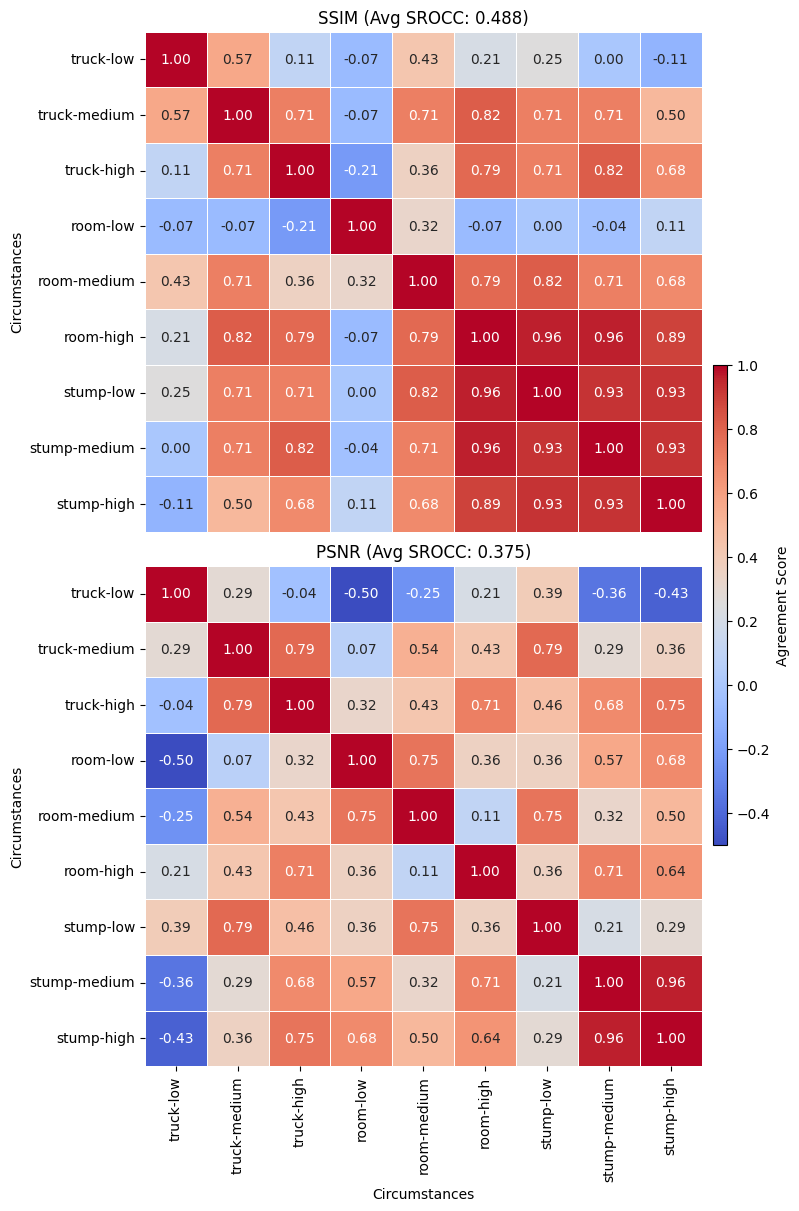

In [16]:
plot_heatmaps(["ssim", "psnr"])

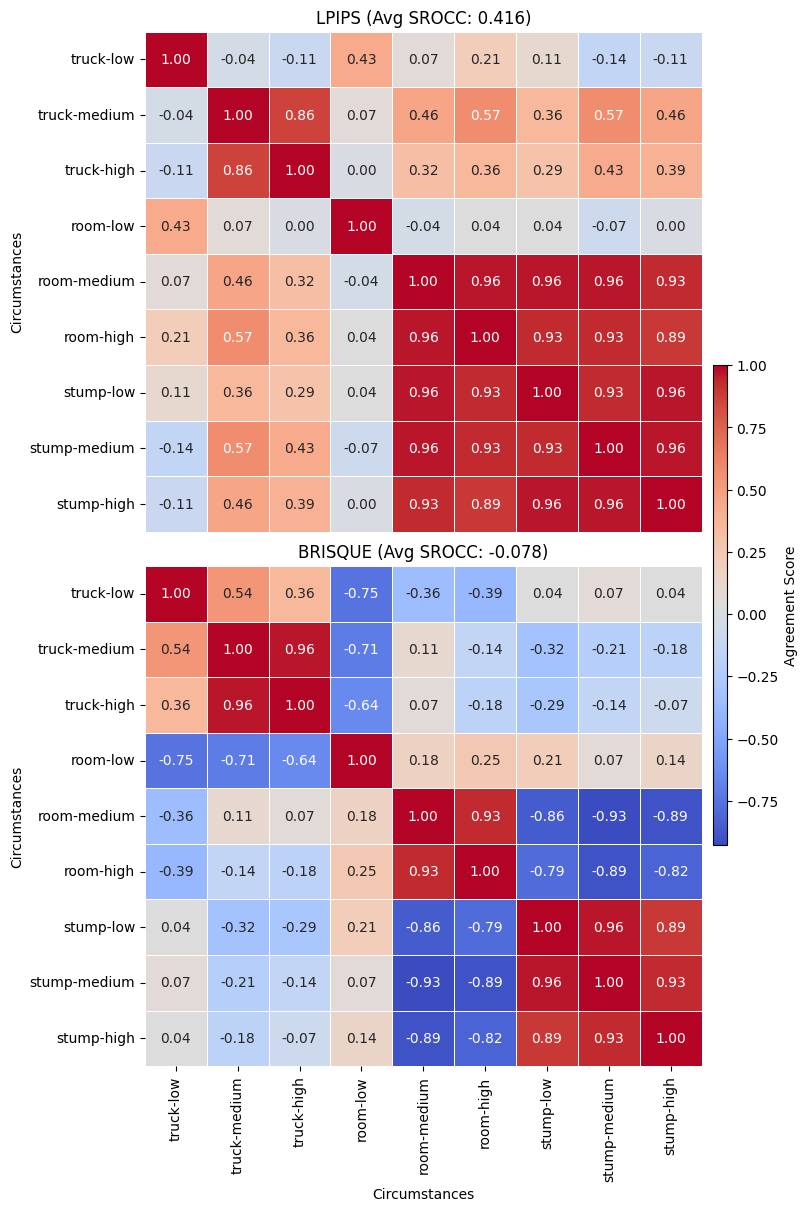

In [17]:
plot_heatmaps(["lpips", "brisque"])

In [18]:
compute_agreement_matrix(metric="ssim")

(truck, low)  (truck, medium)  (truck, high)  (room, low)  \
(truck, low)         1.000000         0.571429       0.107143    -0.071429   
(truck, medium)      0.571429         1.000000       0.714286    -0.071429   
(truck, high)        0.107143         0.714286       1.000000    -0.214286   
(room, low)         -0.071429        -0.071429      -0.214286     1.000000   
(room, medium)       0.428571         0.714286       0.357143     0.321429   
(room, high)         0.214286         0.821429       0.785714    -0.071429   
(stump, low)         0.250000         0.714286       0.714286     0.000000   
(stump, medium)      0.000000         0.714286       0.821429    -0.035714   
(stump, high)       -0.107143         0.500000       0.678571     0.107143   

                 (room, medium)  (room, high)  (stump, low)  (stump, medium)  \
(truck, low)           0.428571      0.214286      0.250000         0.000000   
(truck, medium)        0.714286      0.821429      0.714286         0.714286   
(truck, high)          0.357143      0.785714      0.714286         0.821429   
(room, low)            0.321429     -0.071429      0.000000        -0.035714   
(room, medium)         1.000000      0.785714      0.821429         0.714286   
(room, high)           0.785714      1.000000      0.964286         0.964286   
(stump, low)           0.821429      0.964286      1.000000         0.928571   
(stump, medium)        0.714286      0.964286      0.928571         1.000000   
(stump, high)          0.678571      0.892857      0.928571         0.928571   

                 (stump, high)  
(truck, low)         -0.107143  
(truck, medium)       0.500000  
(truck, high)         0.678571  
(room, low)           0.107143  
(room, medium)        0.678571  
(room, high)          0.892857  
(stump, low)          0.928571  
(stump, medium)       0.928571  
(stump, high)         1.000000

In [19]:
compute_agreement_matrix(metric="lpips")

(truck, low)  (truck, medium)  (truck, high)  (room, low)  \
(truck, low)         1.000000        -0.035714      -0.107143     0.428571   
(truck, medium)     -0.035714         1.000000       0.857143     0.071429   
(truck, high)       -0.107143         0.857143       1.000000     0.000000   
(room, low)          0.428571         0.071429       0.000000     1.000000   
(room, medium)       0.071429         0.464286       0.321429    -0.035714   
(room, high)         0.214286         0.571429       0.357143     0.035714   
(stump, low)         0.107143         0.357143       0.285714     0.035714   
(stump, medium)     -0.142857         0.571429       0.428571    -0.071429   
(stump, high)       -0.107143         0.464286       0.392857     0.000000   

                 (room, medium)  (room, high)  (stump, low)  (stump, medium)  \
(truck, low)           0.071429      0.214286      0.107143        -0.142857   
(truck, medium)        0.464286      0.571429      0.357143         0.571429   
(truck, high)          0.321429      0.357143      0.285714         0.428571   
(room, low)           -0.035714      0.035714      0.035714        -0.071429   
(room, medium)         1.000000      0.964286      0.964286         0.964286   
(room, high)           0.964286      1.000000      0.928571         0.928571   
(stump, low)           0.964286      0.928571      1.000000         0.928571   
(stump, medium)        0.964286      0.928571      0.928571         1.000000   
(stump, high)          0.928571      0.892857      0.964286         0.964286   

                 (stump, high)  
(truck, low)         -0.107143  
(truck, medium)       0.464286  
(truck, high)         0.392857  
(room, low)           0.000000  
(room, medium)        0.928571  
(room, high)          0.892857  
(stump, low)          0.964286  
(stump, medium)       0.964286  
(stump, high)         1.000000

In [20]:
compute_agreement_matrix(metric="brisque")

(truck, low)  (truck, medium)  (truck, high)  (room, low)  \
(truck, low)         1.000000         0.535714       0.357143    -0.750000   
(truck, medium)      0.535714         1.000000       0.964286    -0.714286   
(truck, high)        0.357143         0.964286       1.000000    -0.642857   
(room, low)         -0.750000        -0.714286      -0.642857     1.000000   
(room, medium)      -0.357143         0.107143       0.071429     0.178571   
(room, high)        -0.392857        -0.142857      -0.178571     0.250000   
(stump, low)         0.035714        -0.321429      -0.285714     0.214286   
(stump, medium)      0.071429        -0.214286      -0.142857     0.071429   
(stump, high)        0.035714        -0.178571      -0.071429     0.142857   

                 (room, medium)  (room, high)  (stump, low)  (stump, medium)  \
(truck, low)          -0.357143     -0.392857      0.035714         0.071429   
(truck, medium)        0.107143     -0.142857     -0.321429        -0.214286   
(truck, high)          0.071429     -0.178571     -0.285714        -0.142857   
(room, low)            0.178571      0.250000      0.214286         0.071429   
(room, medium)         1.000000      0.928571     -0.857143        -0.928571   
(room, high)           0.928571      1.000000     -0.785714        -0.892857   
(stump, low)          -0.857143     -0.785714      1.000000         0.964286   
(stump, medium)       -0.928571     -0.892857      0.964286         1.000000   
(stump, high)         -0.892857     -0.821429      0.892857         0.928571   

                 (stump, high)  
(truck, low)          0.035714  
(truck, medium)      -0.178571  
(truck, high)        -0.071429  
(room, low)           0.142857  
(room, medium)       -0.892857  
(room, high)         -0.821429  
(stump, low)          0.892857  
(stump, medium)       0.928571  
(stump, high)         1.000000

### Barplot - Difference to the best model in each facet?


In [21]:
def compute_difference_to_peak() -> pd.DataFrame:
    records = []

    for model in df_metrics["model"].unique():
        for size in ["low", "medium", "high"]:
            for dataset in ["room", "stump", "truck"]:
                df_subset_self = df_metrics[
                    (df_metrics["model"] == model)
                    & (df_metrics["size"] == size)
                    & (df_metrics["dataset"] == dataset)
                ][["psnr", "ssim", "lpips"]].mean()
                df_subset_all = (
                    df_metrics[
                        (df_metrics["size"] == size)
                        & (df_metrics["dataset"] == dataset)
                    ]
                    .groupby("model")[["psnr", "ssim", "lpips"]]
                    .mean()
                )
                records.append(
                    {
                        "model": model,
                        "size": size,
                        "dataset": dataset,
                        "diff_to_best_psnr": df_subset_all["psnr"].max()
                        - df_subset_self["psnr"],
                        "diff_to_best_ssim": df_subset_all["ssim"].max()
                        - df_subset_self["ssim"],
                    }
                )

    return pd.DataFrame.from_records(records)

In [22]:
diff_to_max = compute_difference_to_peak()
diff_to_max

model    size dataset  diff_to_best_psnr  diff_to_best_ssim
0         Default     low    room           0.377805           0.001631
1         Default     low   stump           1.167791           0.044589
2         Default     low   truck           0.654319           0.004377
3         Default  medium    room           0.431146           0.000000
4         Default  medium   stump           1.057566           0.049621
..            ...     ...     ...                ...                ...
58  Mip-Splatting  medium   stump           0.811025           0.050182
59  Mip-Splatting  medium   truck           0.601824           0.004784
60  Mip-Splatting    high    room           0.336409           0.003934
61  Mip-Splatting    high   stump           1.039205           0.050073
62  Mip-Splatting    high   truck           0.468842           0.006564

[63 rows x 5 columns]

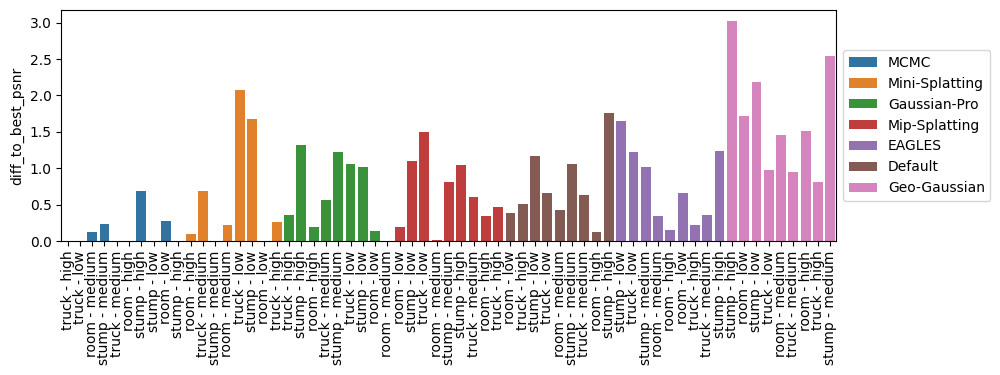

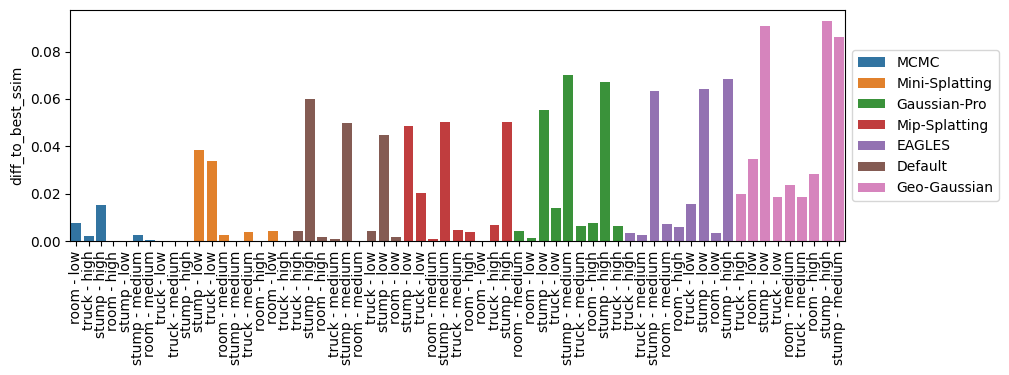

In [23]:
import seaborn as sns


def visualize_diff_to_max(
    df_diff_to_max: pd.DataFrame, var="diff_to_best_psnr", show_ticks=True
):
    df_sorted = df_diff_to_max
    order = df_diff_to_max.groupby("model")[var].sum().sort_values()
    df_sorted["total"] = df_diff_to_max["model"].apply(lambda x: order[x])
    df_sorted = df_sorted.sort_values("total").reset_index()
    fig = plt.figure(figsize=(10, 3))
    sns.barplot(
        data=df_sorted,
        x=df_sorted.index,
        y=var,
        hue="model",
        dodge=False,
        hue_order=hue_order,
    )
    if show_ticks:
        plt.xticks(
            ticks=range(len(df_sorted)),
            labels=df_sorted[["model", "dataset", "size"]]
            .apply(tuple, axis=1)
            .apply(lambda x: f"{x[1]} - {x[2]}"),
            rotation=90,
        )
    else:
        plt.xticks(
            ticks=range(len(df_sorted)),
            labels=["" for _ in range(len(df_sorted))],
        )
    plt.xlabel("")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()


visualize_diff_to_max(diff_to_max)
visualize_diff_to_max(diff_to_max, "diff_to_best_ssim")

### Violinplot - Global score / Borda count


In [24]:
(
    df_metrics[
        [
            "model",
            "brisque",
            "brisque_0",
            "brisque_1",
            "brisque_2",
            "brisque_3",
            "brisque_4",
        ]
    ]
    .melt(id_vars="model")
    .rename({"value": "brisque"}, axis=1)
)

model   variable     brisque
0            Default    brisque  115.171990
1            Default    brisque  115.158895
2            Default    brisque  115.217585
3            Default    brisque  116.012239
4            Default    brisque  116.626857
...              ...        ...         ...
10957  Mip-Splatting  brisque_4  117.910451
10958  Mip-Splatting  brisque_4  117.035761
10959  Mip-Splatting  brisque_4  112.605944
10960  Mip-Splatting  brisque_4  117.000088
10961  Mip-Splatting  brisque_4  116.116521

[10962 rows x 3 columns]

In [25]:
import seaborn as sns


def bootstrap_df(df: pd.DataFrame, n_samples=100):
    for i in range(n_samples):
        yield df.sample(frac=1, replace=True, random_state=i)


def compute_ranking_global_bootstrap(ax: plt.Axes, metric="psnr") -> None:
    df_rankings = None

    for dataset in ["room", "stump", "truck"]:
        for size in ["low", "medium", "high"]:
            df = df_metrics[
                (df_metrics["dataset"] == dataset) & (df_metrics["size"] == size)
            ]
            if metric == "brisque":
                df = (
                    df[
                        [
                            "model",
                            "brisque",
                            "brisque_0",
                            "brisque_1",
                            "brisque_2",
                            "brisque_3",
                            "brisque_4",
                        ]
                    ]
                    .melt(id_vars="model")
                    .rename({"value": "brisque"}, axis=1)
                )
            rankings = []
            for i, df_bootstrap in enumerate(bootstrap_df(df[["model", metric]], 100)):
                mean_metric = df_bootstrap.groupby("model")[metric].mean()
                rankings.append(
                    mean_metric.rank(
                        method="min",
                        ascending=True if metric in ["psnr", "ssim"] else False,
                    ).values
                )
            df_rankings_new = pd.DataFrame(rankings, columns=df["model"].unique())
            df_rankings_new["bs_index"] = list(range(100))
            if df_rankings is None:
                df_rankings = df_rankings_new
            else:
                df_rankings = pd.concat([df_rankings, df_rankings_new])

    df_borda = df_rankings.groupby("bs_index").sum()
    sns.violinplot(
        df_borda.melt(),
        x="variable",
        y="value",
        hue="variable",
        order=df_borda.mean().sort_values(ascending=False).index,
        hue_order=hue_order,
        ax=ax,
    )
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontdict={"size": 14})
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_title(
        f"Global Borda-Count Ranking ({metric.upper()})", fontdict={"size": 18}
    )

/tmp/ipykernel_6190/535120027.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontdict={"size": 14})
/tmp/ipykernel_6190/535120027.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontdict={"size": 14})
/tmp/ipykernel_6190/535120027.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontdict={"size": 14})
/tmp/ipykernel_6190/535120027.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontdict={"size": 14})


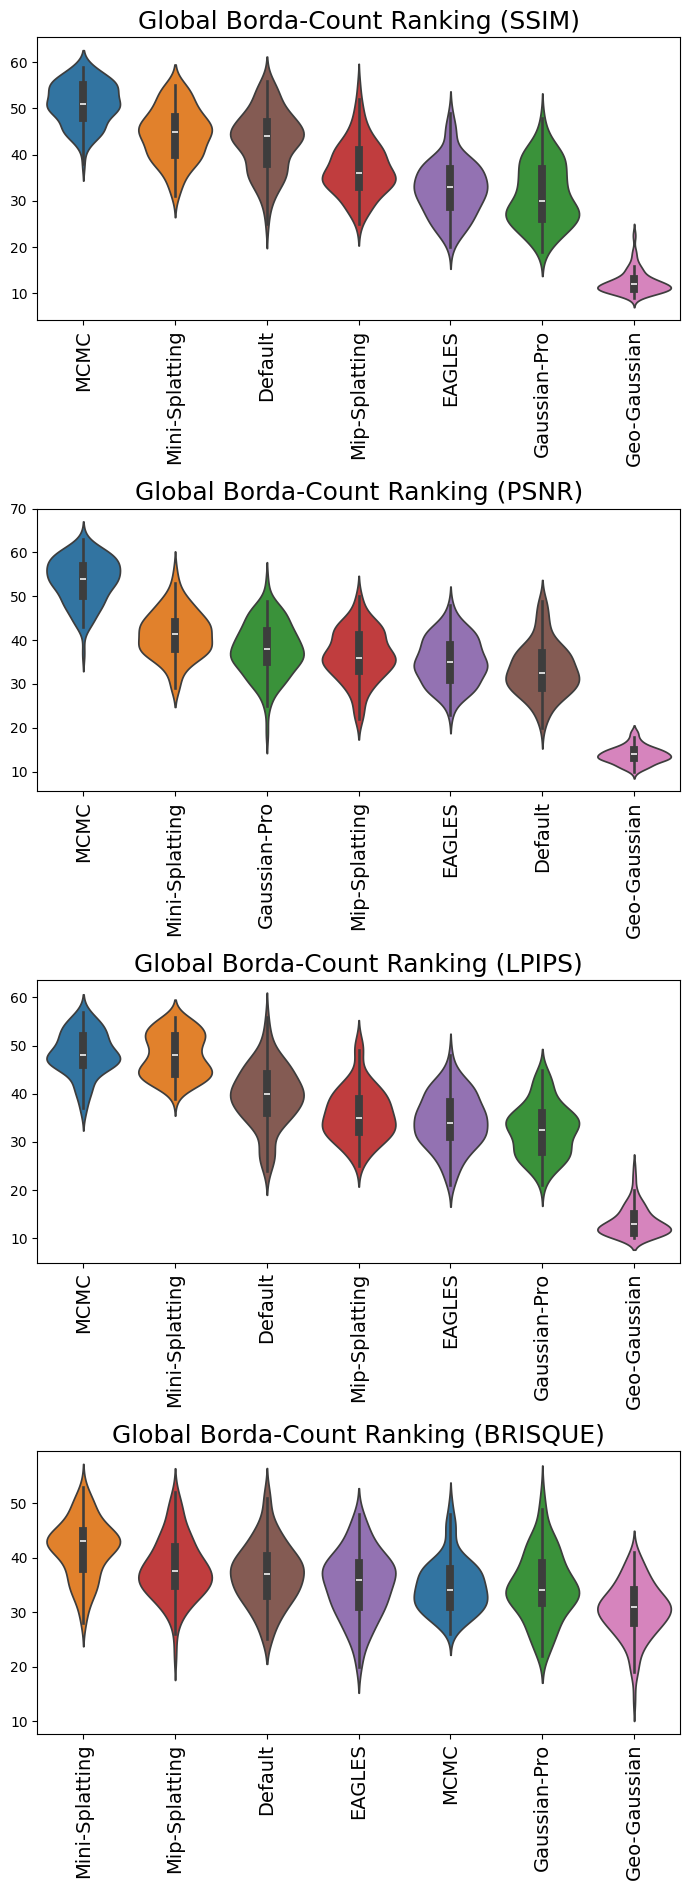

In [26]:
fig, axs = plt.subplots(4, 1, figsize=(7, 19))

for i, metric in enumerate(["ssim", "psnr", "lpips", "brisque"]):
    compute_ranking_global_bootstrap(axs[i], metric=metric)
    plt.tight_layout()
plt.savefig(
    "/home/paul/TUWien/MasterThesisNerf/thesis-document/graphics/results/objective/overall-rankings.png",
    bbox_inches="tight",
    pad_inches=0.1,
)

### Kendalls W


In [27]:
objective_kendall_ssim = (
    df_metrics.groupby(["model", "dataset", "size"])["ssim"].mean().unstack(level=0)
)
objective_kendall_psnr = (
    df_metrics.groupby(["model", "dataset", "size"])["psnr"].mean().unstack(level=0)
)


def compute_kendall(data: pd.DataFrame) -> float:
    ranked_data = data.rank(axis=1)

    m, n = ranked_data.shape

    R_i = ranked_data.sum(axis=0)
    S = ((R_i - R_i.mean()) ** 2).sum()

    return 12 * S / (m**2 * (n**3 - n))


print(f"Kendall's W (SSIM): {compute_kendall(objective_kendall_ssim):.4f}")
print(f"Kendall's W (PSNR): {compute_kendall(objective_kendall_psnr):.4f}")

Kendall's W (SSIM): 0.5450
Kendall's W (PSNR): 0.4444


In [28]:
import pingouin as pg

pg.friedman(objective_kendall_ssim)

Source         W  ddof1          Q    p-unc
Friedman  Within  0.544974      6  29.428571  0.00005

### PCA


#### PCA on methods


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


def pca_project_methods(ax: plt.Axes, metric="ssim") -> None:
    data = (
        df_metrics.groupby(["model", "dataset", "size"])[metric].mean().unstack(level=0)
    )

    # Standardize the data (important for PCA)
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data.transpose())

    # Apply PCA
    pca = PCA(n_components=2)  # Keep all components
    pca.fit(data_scaled)

    data_pca = pca.transform(data_scaled)

    ax.scatter(data_pca[:, 0], data_pca[:, 1], c="b", edgecolors="k")
    for i, method in enumerate(data.columns):
        ax.annotate(method, (data_pca[i, 0] + 0.05, data_pca[i, 1] + 0.05))
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_title(f"PCA Projection of Methods ({metric})")
    ax.grid()

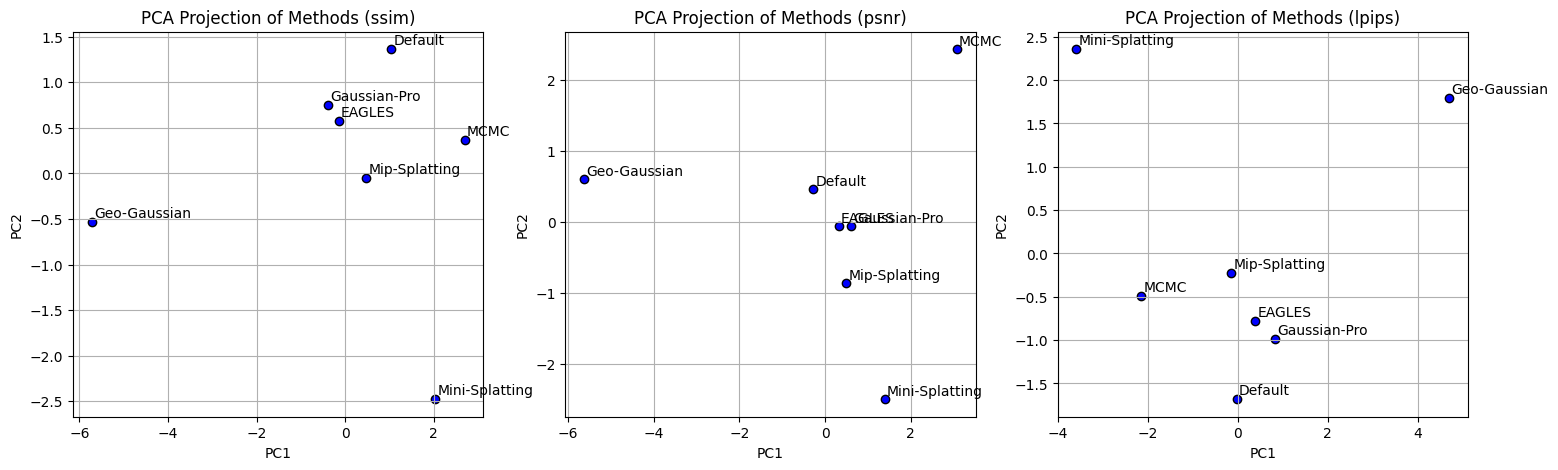

In [30]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for i, metric in enumerate(["ssim", "psnr", "lpips"]):
    pca_project_methods(axs[i], metric=metric)

#### PCA on facets


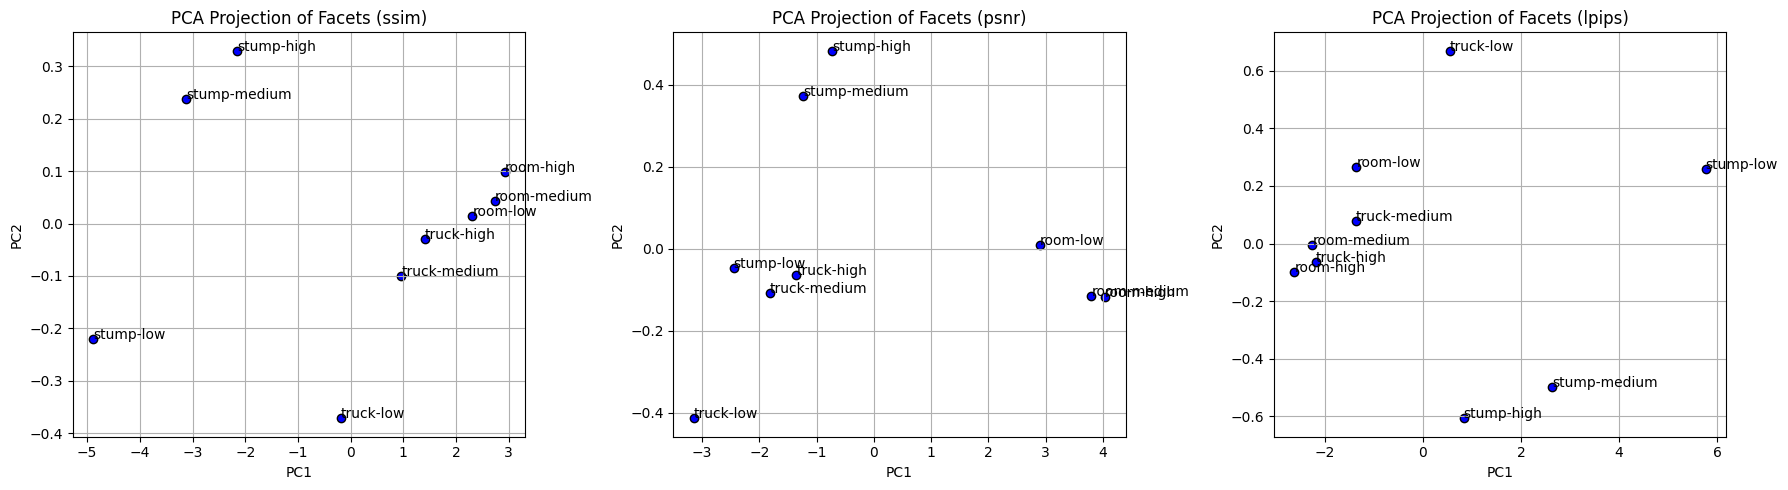

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


def pca_project_facets(ax: plt.Axes, metric="ssim") -> None:
    data = (
        df_metrics.groupby(["model", "dataset", "size"])[metric].mean().unstack(level=0)
    )

    # Standardize the data (important for PCA)
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # Apply PCA
    pca = PCA(n_components=2)  # Keep all components
    pca.fit(data_scaled)

    data_pca = pca.transform(data_scaled)

    ax.scatter(data_pca[:, 0], data_pca[:, 1], c="b", edgecolors="k")
    for i, facet in enumerate([f"{x[0]}-{x[1]}" for x in data.index.values]):
        ax.annotate(facet, (data_pca[i, 0], data_pca[i, 1]))
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_title(f"PCA Projection of Facets ({metric})")
    ax.grid()


fig, ax = plt.subplots(1, 3, figsize=(18, 5))

for i, metric in enumerate(["ssim", "psnr", "lpips"]):
    pca_project_facets(ax[i], metric=metric)
plt.tight_layout()

## Subjective Ranking


In [32]:
df_jod_cv_20 = pd.read_excel("data/jod_k_fold_20.xlsx").rename(rename_jod, axis=1)
df_jod_cv_20

Unnamed: 0  size dataset  fold_idx   Default      MCMC  Mini-Splatting  \
0             0   low    room         0  1.768779  0.272103       -0.311784   
1             1   low    room         1  1.312686  0.045694        0.207886   
2             2   low    room         2  1.252760 -0.258412        0.012632   
3             3   low    room         3  1.144164  0.051849        0.009823   
4             4   low    room         4  1.506414  0.005924        0.010334   
..          ...   ...     ...       ...       ...       ...             ...   
175         175  high   truck        15 -0.581348 -0.430886       -0.311576   
176         176  high   truck        16  0.050276  0.623271        0.378886   
177         177  high   truck        17 -0.598654 -0.688189       -0.703862   
178         178  high   truck        18 -0.356591 -1.345741       -0.009200   
179         179  high   truck        19 -0.583647 -0.556784       -0.297756   

       EAGLES  Mip-Splatting  Gaussian-Pro  Geo-Gaussian  
0   -1.244932       0.540271     -0.262887     -0.761549  
1   -1.379588       0.860618     -0.376107     -0.671182  
2   -0.933280       0.362009      0.120224     -0.555937  
3   -0.926181       0.501579     -0.115509     -0.665725  
4   -0.951396       0.206201     -0.182962     -0.594518  
..        ...            ...           ...           ...  
175  1.837878       0.393985      0.995497     -1.903549  
176  2.621602       1.257902      1.771347     -6.703305  
177  2.077047       0.944845      1.048118     -2.079309  
178  2.062174       0.657146      1.165012     -2.172805  
179  1.668705       0.521776      1.187492     -1.939791  

[180 rows x 11 columns]

### Violinplot - Global Score by Borda Count


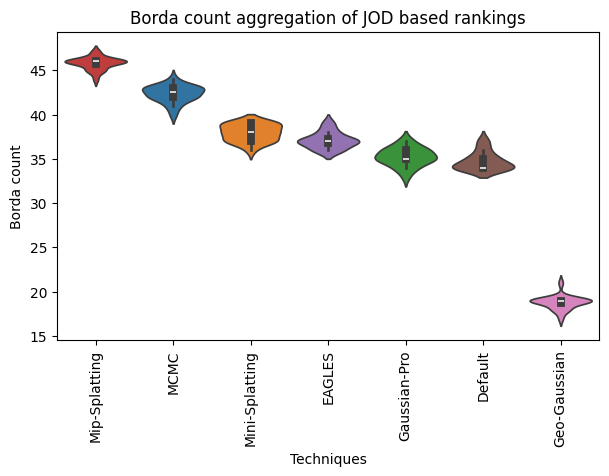

In [33]:
records = []
for idx, row in df_jod_cv_20.iterrows():
    ranks = (
        row[
            [
                "Default",
                "MCMC",
                "Mini-Splatting",
                "EAGLES",
                "Mip-Splatting",
                "Gaussian-Pro",
                "Geo-Gaussian",
            ]
        ]
        .rank(method="min", ascending=True)
        .to_dict()
    )
    records.append(
        {
            "fold_idx": row["fold_idx"],
            **ranks,
        }
    )


df_borda = pd.DataFrame.from_records(records).groupby("fold_idx").sum()
df_borda
fig, ax = plt.subplots(figsize=(7, 4))
sns.violinplot(
    df_borda.melt(),
    x="variable",
    y="value",
    hue="variable",
    order=df_borda.mean().sort_values(ascending=False).index,
    hue_order=hue_order,
    ax=ax,
)
plt.xticks(rotation=90)
ax.set_xlabel("Techniques")
ax.set_ylabel("Borda count")
ax.set_title("Borda count aggregation of JOD based rankings")
plt.savefig(
    "/home/paul/TUWien/MasterThesisNerf/thesis-document/graphics/results/subjective/borda-count-jod-rankings.png",
    bbox_inches="tight",
    pad_inches=0.1,
)

### Barplot - Mode

In [34]:
ranks = df_jod.iloc[:,3:].rank(axis=1)

Text(0.5, 1.0, 'Most Common Rank across all 9 circumstances, higher is better')

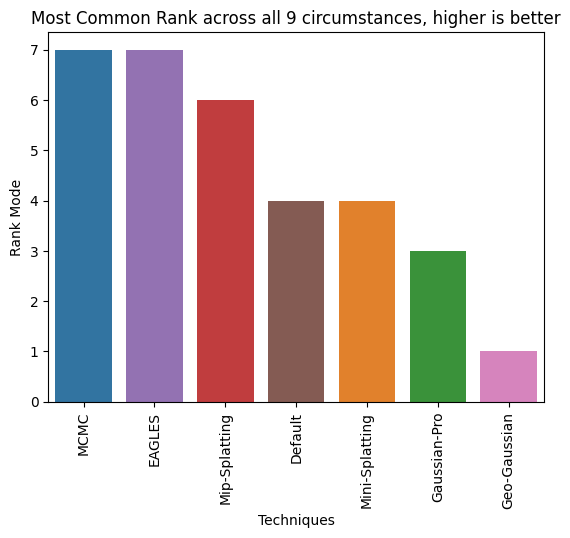

In [35]:
mode = (
    ranks
    .mode(axis=0)
    .transpose()
    .sort_values(0, ascending=False)
).reset_index()
sns.barplot(
    mode,
    x="index",
    y=0,
    hue_order=hue_order,
    hue="index"
)
plt.xticks(rotation=90)
plt.xlabel("Techniques")
plt.ylabel("Rank Mode")
plt.title("Most Common Rank across all 9 circumstances, higher is better")

### Boxplot - Rank Distribution

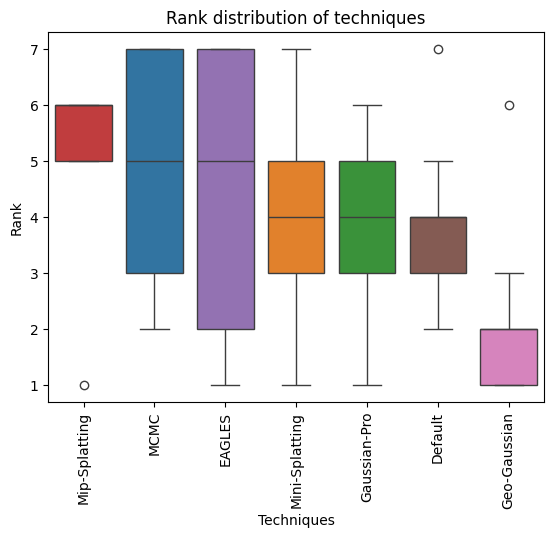

In [36]:
ranks_melt = ranks.melt()
median = ranks_melt.groupby("variable").median().sort_values("value")
mean = ranks_melt.groupby("variable").mean().sort_values("value")
ranks_melt = ranks_melt.sort_values(
    "variable",
    key=lambda v: mean.loc[v]["value"] + median.loc[v]["value"],
    ascending=False,
)
sns.boxplot(ranks_melt, x="variable", y="value", hue="variable", hue_order=hue_order)
plt.title("Rank distribution of techniques")
plt.xlabel("Techniques")
plt.ylabel("Rank")
plt.xticks(rotation=90)
plt.savefig(
    "/home/paul/TUWien/MasterThesisNerf/thesis-document/graphics/conclusion/rank-distribution.png",
    bbox_inches="tight",
    pad_inches=0.1,
)

### Violinplot - facet by facet


In [37]:
def plot_facet_by_facet_jod_ranking(dataset: str, size: str, ax: plt.Axes) -> None:
    df_subset = df_jod_cv_20[
        (df_jod_cv_20["dataset"] == dataset) & (df_jod_cv_20["size"] == size)
    ]

    df_subset = df_subset[
        [
            "Default",
            "MCMC",
            "Mini-Splatting",
            "EAGLES",
            "Mip-Splatting",
            "Gaussian-Pro",
            "Geo-Gaussian",
        ]
    ]
    df_subset.melt()

    sns.violinplot(
        df_subset.melt(),
        x="variable",
        y="value",
        hue="variable",
        order=df_subset.mean().sort_values(ascending=False).index,
        hue_order=hue_order,
        ax=ax,
    )
    ax.tick_params(labelrotation=90)
    ax.set_title(f"Ranking by JOD - {dataset}-{size}")
    ax.set_xlabel("Method")
    ax.set_ylabel("JOD")

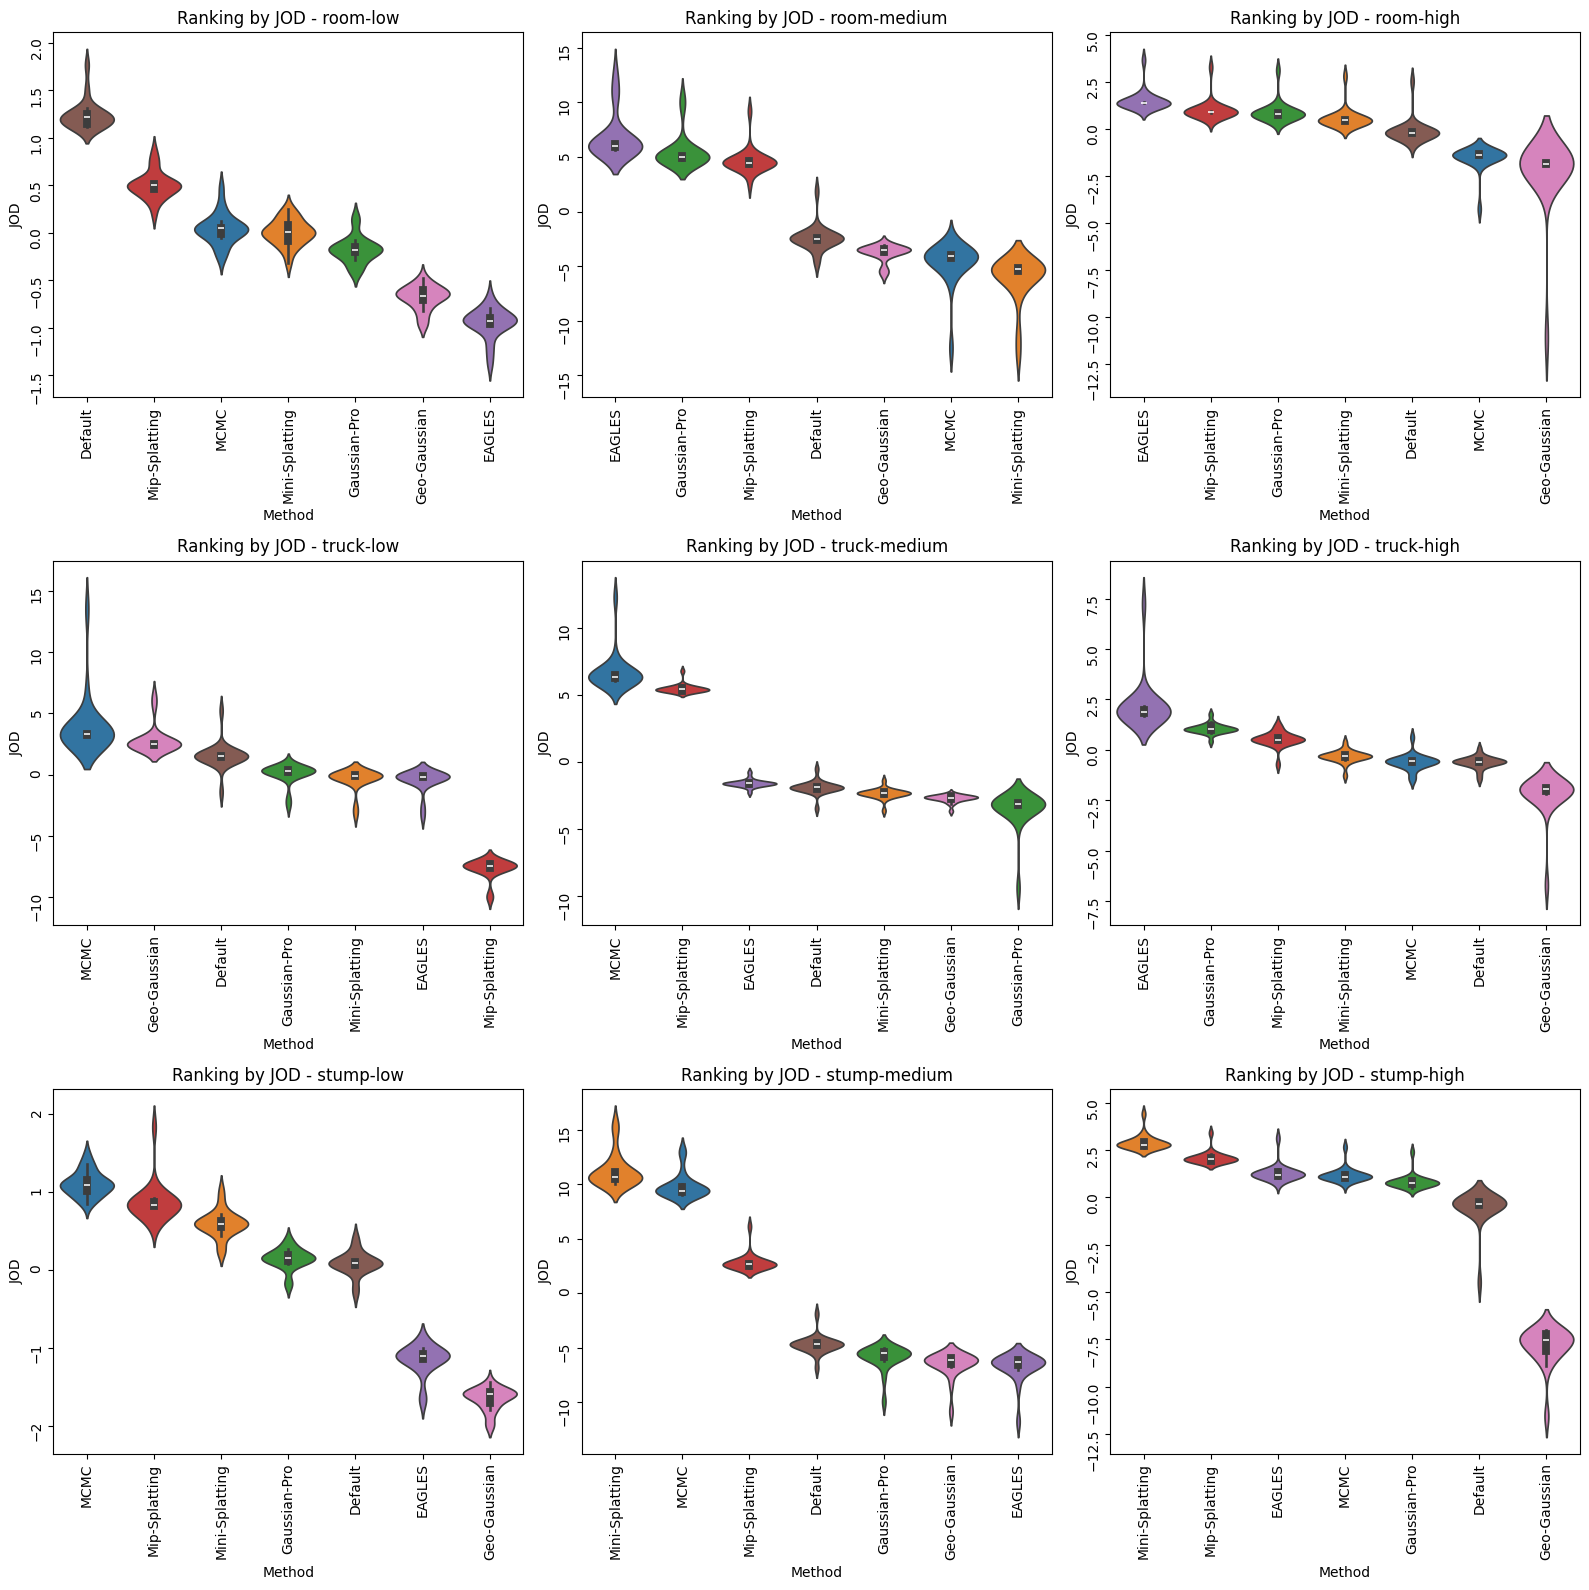

In [38]:
fig, axs = plt.subplots(3, 3, figsize=(16, 16))
for i, dataset in enumerate(["room", "truck", "stump"]):
    for j, size in enumerate(["low", "medium", "high"]):
        plot_facet_by_facet_jod_ranking(dataset, size, axs[i][j])
plt.tight_layout()
plt.show()

### Violinplot - Subset based borda count


In [39]:
df_jod_cv_20

Unnamed: 0  size dataset  fold_idx   Default      MCMC  Mini-Splatting  \
0             0   low    room         0  1.768779  0.272103       -0.311784   
1             1   low    room         1  1.312686  0.045694        0.207886   
2             2   low    room         2  1.252760 -0.258412        0.012632   
3             3   low    room         3  1.144164  0.051849        0.009823   
4             4   low    room         4  1.506414  0.005924        0.010334   
..          ...   ...     ...       ...       ...       ...             ...   
175         175  high   truck        15 -0.581348 -0.430886       -0.311576   
176         176  high   truck        16  0.050276  0.623271        0.378886   
177         177  high   truck        17 -0.598654 -0.688189       -0.703862   
178         178  high   truck        18 -0.356591 -1.345741       -0.009200   
179         179  high   truck        19 -0.583647 -0.556784       -0.297756   

       EAGLES  Mip-Splatting  Gaussian-Pro  Geo-Gaussian  
0   -1.244932       0.540271     -0.262887     -0.761549  
1   -1.379588       0.860618     -0.376107     -0.671182  
2   -0.933280       0.362009      0.120224     -0.555937  
3   -0.926181       0.501579     -0.115509     -0.665725  
4   -0.951396       0.206201     -0.182962     -0.594518  
..        ...            ...           ...           ...  
175  1.837878       0.393985      0.995497     -1.903549  
176  2.621602       1.257902      1.771347     -6.703305  
177  2.077047       0.944845      1.048118     -2.079309  
178  2.062174       0.657146      1.165012     -2.172805  
179  1.668705       0.521776      1.187492     -1.939791  

[180 rows x 11 columns]

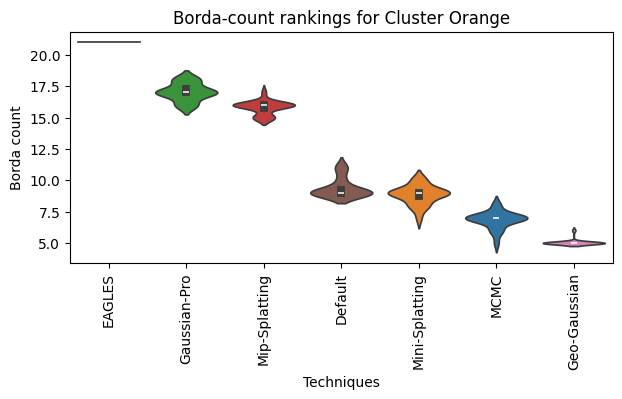

In [40]:
from typing import List, Tuple


def compute_subset_based_borda_count(subset_circumstances: List[Tuple[str, str]]):
    records = []
    for idx, row in df_jod_cv_20.iterrows():
        any_match = False
        for dataset, size in subset_circumstances:
            if row["size"] == size and row["dataset"] == dataset:
                any_match = True
        if any_match:
            ranks = (
                row[
                    [
                        "Default",
                        "MCMC",
                        "Mini-Splatting",
                        "EAGLES",
                        "Mip-Splatting",
                        "Gaussian-Pro",
                        "Geo-Gaussian",
                    ]
                ]
                .rank(method="min", ascending=True)
                .to_dict()
            )
            records.append(
                {
                    "fold_idx": row["fold_idx"],
                    **ranks,
                }
            )

    df_borda = pd.DataFrame.from_records(records).groupby("fold_idx").sum()
    fig, ax = plt.subplots(figsize=(7, 3))
    sns.violinplot(
        df_borda.melt(),
        x="variable",
        y="value",
        hue="variable",
        order=df_borda.mean().sort_values(ascending=False).index,
        hue_order=hue_order,
        ax=ax,
    )
    plt.xticks(rotation=90)
    ax.set_xlabel("Techniques")
    ax.set_ylabel("Borda count")
    ax.set_title("Borda count aggregation of JOD based rankings")


cluster_orange = [
    ("room", "medium"),
    ("room", "high"),
    ("truck", "high"),
]
compute_subset_based_borda_count(cluster_orange)
plt.title("Borda-count rankings for Cluster Orange")
plt.savefig(
    "/home/paul/TUWien/MasterThesisNerf/thesis-document/graphics/results/subjective/borda-count-cluster-orange-rankings.png",
    bbox_inches="tight",
    pad_inches=0.1,
)

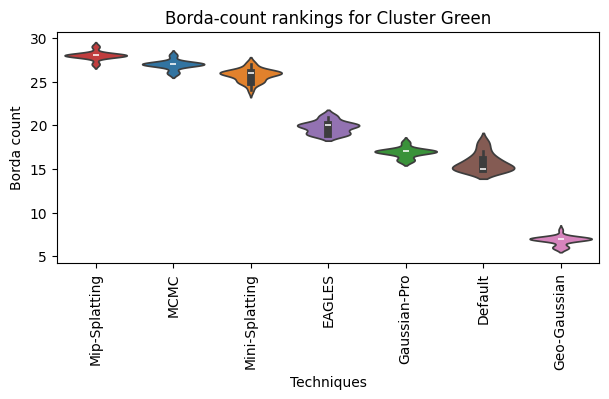

In [41]:
cluster_green = [
    ("stump", "low"),
    ("stump", "medium"),
    ("stump", "high"),
    ("truck", "medium"),
    ("truck", "high"),
]

compute_subset_based_borda_count(cluster_green)
plt.title("Borda-count rankings for Cluster Green")
plt.savefig(
    "/home/paul/TUWien/MasterThesisNerf/thesis-document/graphics/results/subjective/borda-count-cluster-green-rankings.png",
    bbox_inches="tight",
    pad_inches=0.1,
)

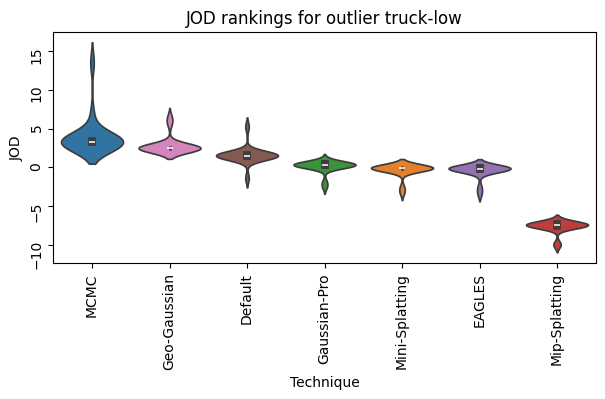

In [42]:
single_blue = [
    ("truck", "low"),
]

fig, ax = plt.subplots(figsize=(7, 3))
plot_facet_by_facet_jod_ranking("truck", "low", ax)
plt.title("JOD rankings for outlier truck-low")
plt.xlabel("Technique")
plt.savefig(
    "/home/paul/TUWien/MasterThesisNerf/thesis-document/graphics/results/subjective/outlier-blue-rankings.png",
    bbox_inches="tight",
    pad_inches=0.1,
)

### Kendalls W


In [43]:
kendalls = [
    compute_kendall(df_jod_cv_20[df_jod_cv_20["fold_idx"] == fold_idx].iloc[:, 4:])
    for fold_idx in df_jod_cv_20["fold_idx"].unique()
]
print(f"Kendalls W {np.mean(kendalls):.4f} +- {np.std(kendalls) * 1.96:.4f} ci")

Kendalls W 0.1961 +- 0.0288 ci


(0.0, 1.0)

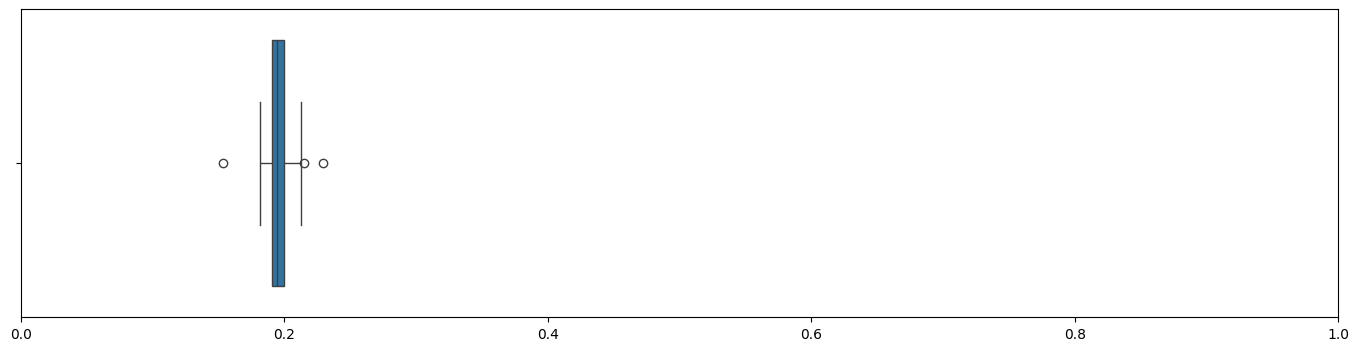

In [44]:
plt.figure(figsize=(17, 4))
sns.boxplot(kendalls, orient="h")
plt.xlim(0, 1)

### Heatmap - Facet by Facet correlation


In [45]:
df_jod

Unnamed: 0    size dataset   Default       MCMC  Mini-Splatting    EAGLES  \
0           0     low    room  1.224958   0.043442        0.009125 -0.935775   
1           1     low   stump  0.084604   1.091317        0.588852 -1.130980   
2           2     low   truck  1.508159   3.304052       -0.125032 -0.200535   
3           3  medium    room -2.426513  -4.119895       -5.308643  5.985081   
4           4  medium   stump -5.231148  10.146393       11.993272 -6.913767   
5           5  medium   truck -1.899611   6.334341       -2.351148 -1.587518   
6           6    high    room -0.216107  -1.399963        0.444941  1.377899   
7           7    high   stump -0.112904   1.346946        3.049269  1.452908   
8           8    high   truck -0.600466  -0.584095       -0.320281  1.905477   

   Mip-Splatting  Gaussian-Pro  Geo-Gaussian  
0       0.503723     -0.176024     -0.669447  
1       0.846621      0.147880     -1.628307  
2      -7.268494      0.304353      2.477473  
3       4.414793      4.969437     -3.514271  
4       2.800127     -6.085657     -6.709243  
5       5.380465     -3.194218     -2.682348  
6       0.890529      0.776406     -1.873711  
7       2.254115      1.004840     -8.995284  
8       0.528105      1.033350     -1.962093

In [46]:
import seaborn as sns
import itertools
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

val_cols = [
    "Default",
    "MCMC",
    "Mini-Splatting",
    "EAGLES",
    "Mip-Splatting",
    "Gaussian-Pro",
    "Geo-Gaussian",
]


def compute_agreement_measure(series1, series2, measure: str):
    if measure == "SROCC":
        srocc, _ = stats.spearmanr(series1, series2)
        return srocc
    if measure == "Footrule":
        footrule_distance = np.sum(np.abs(series1.rank() - series2.rank()))
        return footrule_distance
    if measure == "Norm_Footrule":
        footrule_distance = np.sum(np.abs(series1.rank() - series2.rank()))
        max_distance = (len(series1) ** 2 - 1) / 2  # max F = (n(n-1))/2
        normalized_footrule = (
            1 - (footrule_distance / max_distance) if max_distance > 0 else 1
        )
        return normalized_footrule


def compute_agreement_matrix_subjective(measure="SROCC"):
    # Extract unique circumstances
    unique_datasets = df_jod["dataset"].unique()
    unique_sizes = df_jod["size"].unique()
    circumstances = list(itertools.product(unique_datasets, unique_sizes))

    # Initialize an empty 9x9 matrix
    n = len(circumstances)
    agreement_matrix = np.zeros((n, n), dtype=np.double)

    for i, (dataset1, size1) in enumerate(circumstances):
        for j, (dataset2, size2) in enumerate(circumstances):
            if i == j:
                agreement_matrix[i, j] = 1.0  # Perfect agreement with itself
                continue

            # Get rankings for each circumstance
            subset1 = df_jod[
                (df_jod["dataset"] == dataset1) & (df_jod["size"] == size1)
            ][val_cols].melt()["value"]
            subset2 = df_jod[
                (df_jod["dataset"] == dataset2) & (df_jod["size"] == size2)
            ][val_cols].melt()["value"]

            # Compute Spearman's Rank Correlation Coefficient (SROCC)

            agreement_matrix[i, j] = compute_agreement_measure(
                subset1, subset2, measure
            )

    # Convert to DataFrame for plotting
    agreement_df = pd.DataFrame(
        agreement_matrix, index=circumstances, columns=circumstances
    )

    return agreement_df

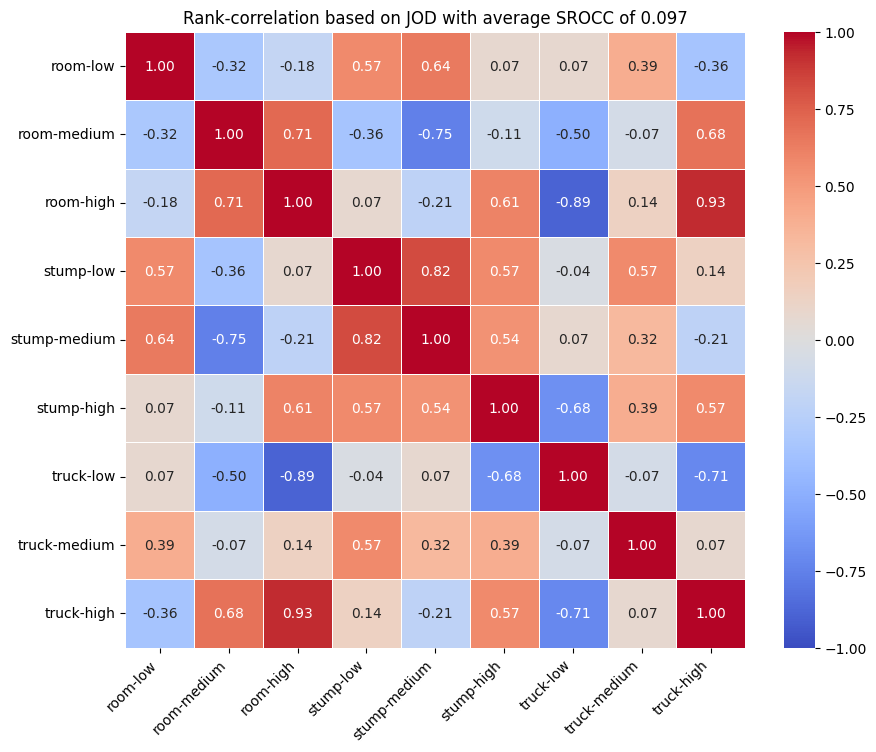

In [47]:
subjective_agreement = compute_agreement_matrix_subjective()

ticks = [f"{x[0]}-{x[1]}" for x in subjective_agreement.index.values]

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    subjective_agreement,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    vmin=-1.0,
    vmax=1.0,
    xticklabels=ticks,
    yticklabels=ticks,
)
plt.title(
    f"Rank-correlation based on JOD with average SROCC of {compute_average_agreement(subjective_agreement):.3f}"
)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.savefig(
    "/home/paul/TUWien/MasterThesisNerf/thesis-document/graphics/results/subjective/jod-rankings-agreement-matrix.png",
    bbox_inches="tight",
    pad_inches=0.1,
)

/tmp/ipykernel_6190/2338409413.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


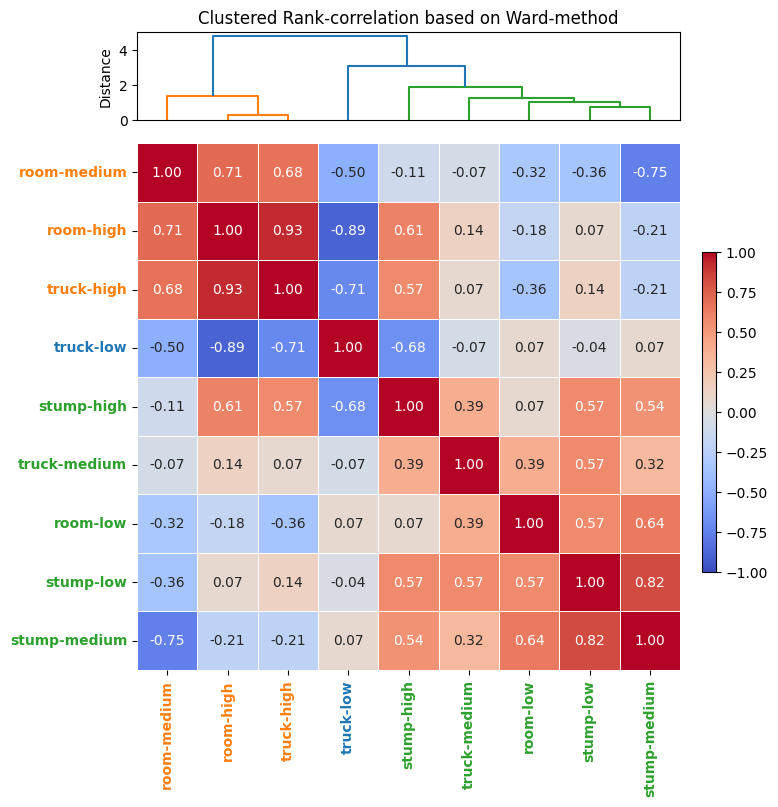

In [48]:
import scipy.cluster.hierarchy as sch


def plot_clustered_agreement_matrix(agreement_matrix):
    # Perform hierarchical clustering on the matrix
    linkage = sch.linkage(agreement_matrix, method="ward")  # Agglomerative clustering
    # sch.dendrogram(linkage, no_plot=True)
    dendro = sch.dendrogram(linkage, no_plot=True, color_threshold=2.1)
    dendro_order = dendro["leaves"]
    leaf_colors = dendro["leaves_color_list"]  # Extract colors

    # Reorder the DataFrame based on clustering
    clustered_matrix = agreement_matrix.iloc[dendro_order, dendro_order]
    ticks = [f"{x[0]}-{x[1]}" for x in clustered_matrix.index]

    fig, ax = plt.subplots(2, 1, figsize=(7, 8), gridspec_kw={"height_ratios": [1, 6]})

    # Plot dendrogram
    sch.dendrogram(
        linkage,
        leaf_rotation=90,
        ax=ax[0],
        labels=agreement_matrix.index,
        color_threshold=2.1,
    )
    ax[0].set_xticklabels([])
    # ax[0].set_yticks([])
    ax[0].set_ylabel("Distance")

    # Plot heatmap with reordered values
    sns.heatmap(
        clustered_matrix,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        linewidths=0.5,
        vmin=-1.0,
        vmax=1.0,
        yticklabels=ticks,
        xticklabels=ticks,
        ax=ax[1],
        cbar=False,
    )

    # Create a new **external color bar**
    cbar_ax = fig.add_axes(
        [1.01, 0.3, 0.02, 0.4]
    )  # Position: [left, bottom, width, height]
    norm = plt.Normalize(vmin=-1.0, vmax=1.0)
    sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
    fig.colorbar(sm, cax=cbar_ax)

    # Apply colors to tick labels
    for label, color in zip(ax[1].get_xticklabels(), leaf_colors):
        label.set_color(color)
        label.set_fontweight("bold")
    for label, color in zip(ax[1].get_yticklabels(), leaf_colors):
        label.set_color(color)
        label.set_fontweight("bold")

    # ax[1].set_title(f"Clustered Agreement Matrix JOD")
    plt.subplots_adjust(wspace=0)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()

    ax[0].set_title("Clustered Rank-correlation based on Ward-method")


plot_clustered_agreement_matrix(subjective_agreement)
plt.savefig(
    "/home/paul/TUWien/MasterThesisNerf/thesis-document/graphics/results/subjective/rank-correlation-clustered.png",
    bbox_inches="tight",
    pad_inches=0.1,
)

### PCA


#### PCA on methods


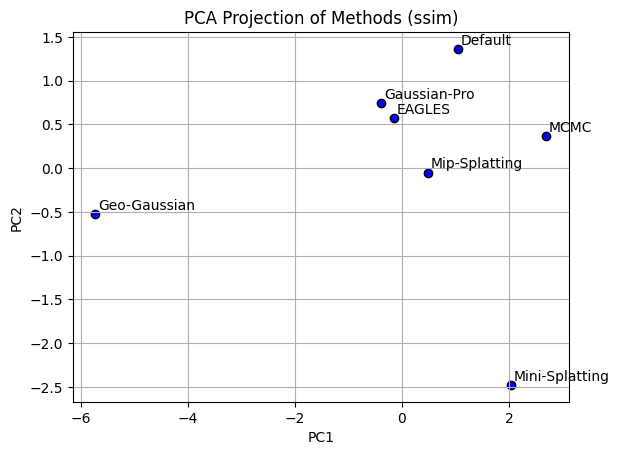

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


def pca_project_jod_methods(ax: plt.Axes) -> None:
    data = df_jod_cv_20.groupby(["dataset", "size"]).mean().iloc[:, 2:]
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data.transpose())

    # Apply PCA
    pca = PCA(n_components=2)  # Keep all components
    pca.fit(data_scaled)

    data_pca = pca.transform(data_scaled)

    ax.scatter(data_pca[:, 0], data_pca[:, 1], c="b", edgecolors="k")
    for i, method in enumerate(data.columns):
        ax.annotate(method, (data_pca[i, 0] + 0.05, data_pca[i, 1] + 0.05))
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_title(f"PCA Projection of Methods (JOD)")
    ax.grid()


fig, ax = plt.subplots(1, 1)
pca_project_methods(ax)

#### PCA on facets


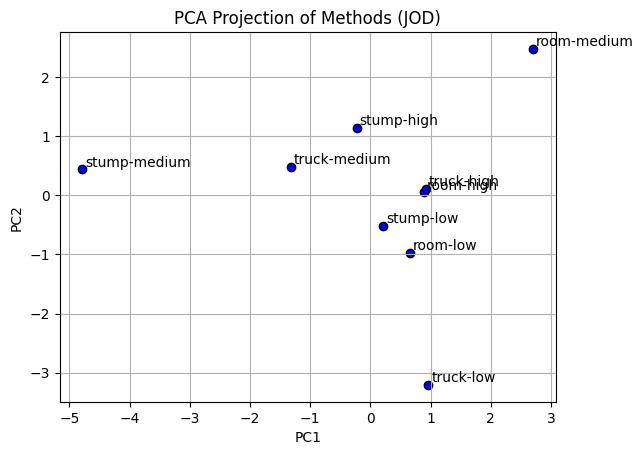

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


def pca_project_jod_facets(ax: plt.Axes) -> None:
    data = df_jod_cv_20.groupby(["dataset", "size"]).mean().iloc[:, 2:]
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # Apply PCA
    pca = PCA(n_components=2)  # Keep all components
    pca.fit(data_scaled)

    data_pca = pca.transform(data_scaled)

    ax.scatter(data_pca[:, 0], data_pca[:, 1], c="b", edgecolors="k")
    for i, (dataset, size) in enumerate(data.index):
        ax.annotate(f"{dataset}-{size}", (data_pca[i, 0] + 0.05, data_pca[i, 1] + 0.05))
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_title(f"PCA Projection of Methods (JOD)")
    ax.grid()


fig, ax = plt.subplots(1, 1)
pca_project_jod_facets(ax)

## Correlation Analysis

So given my JOD values, what kind of correlation could I even compute?

For each facet of my data I can create scatterplot where one observation is a method.


### Scatterplots - facet by facet


In [51]:
from typing import Dict
from matplotlib import pyplot as plt
from scipy.stats import pearsonr, norm, spearmanr
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


def compute_linear_rmse(x, y) -> float:
    X = x.values.reshape(-1, 1)  # Reshape for sklearn
    y = y.values

    linear_model = LinearRegression()
    linear_model.fit(X, y)
    y_pred_linear = linear_model.predict(X)
    rmse_linear = np.sqrt(mean_squared_error(y, y_pred_linear))
    return rmse_linear


def compute_nonlinear_rmse(x, y) -> float:
    X = x.values.reshape(-1, 1)  # Reshape for sklearn
    y = y.values

    # Nonlinear (Quadratic) Regression
    X_nonlinear = np.column_stack((X, X**2))  # Add x^2 term
    nonlinear_model = (
        LinearRegression()
    )  # Still use linear regression, but with transformed features
    nonlinear_model.fit(X_nonlinear, y)
    y_pred_nonlinear = nonlinear_model.predict(X_nonlinear)
    rmse_nonlinear = np.sqrt(mean_squared_error(y, y_pred_nonlinear))
    return rmse_nonlinear


def compute_spearman(x, y) -> float:
    corr, _ = spearmanr(x, y)
    return corr


def compute_pearsonr(x, y) -> float:
    corr, _ = pearsonr(x, y)
    return corr


def plot_quality_metric_against_jod_by_facet(quality_metric: str = "psnr") -> None:
    fig, axs = plt.subplots(3, 3)

    for i, dataset in enumerate(df_metrics["dataset"].unique()):
        for j, size in enumerate(["low", "medium", "high"]):
            single_facet_df = join_quality_metrics_by_facet(
                quality_metric, dataset, size
            )
            axs[i][j].scatter(single_facet_df["jod"], single_facet_df[quality_metric])

    fig.suptitle(quality_metric)
    plt.show()


def plot_quality_metric_against_jod(quality_metric: str = "psnr") -> None:
    df = join_quality_metrics(quality_metric)
    plt.scatter(df["jod"], df[quality_metric])

    plt.suptitle(quality_metric)
    plt.show()


def join_quality_metrics(quality_metric: str) -> pd.DataFrame:
    df_jod_agg = df_jod.melt(
        id_vars=["dataset", "size"],
        value_vars=[
            "Default",
            "MCMC",
            "Mini-Splatting",
            "EAGLES",
            "Mip-Splatting",
            "Gaussian-Pro",
            "Geo-Gaussian",
        ],
    ).rename({"variable": "model", "value": "jod"}, axis=1)
    df_jod_agg["model"] = df_jod_agg["model"]
    df_jod_agg = df_jod_agg.set_index(["model", "dataset", "size"])
    df_metrics_agg = df_metrics.groupby(["model", "dataset", "size"])[
        [quality_metric]
    ].mean()
    return df_jod_agg.join(df_metrics_agg)


def join_quality_metrics_by_facet(
    quality_metric: str, dataset: str, size: str
) -> pd.DataFrame:
    single_facet_df = (
        df_jod[(df_jod["dataset"] == dataset) & (df_jod["size"] == size)]
        .transpose()
        .iloc[3:]
        .rename(lambda x: "jod", axis=1)
    )
    metrics_df = aggregate_metrics_by_facet(df_metrics, quality_metric, dataset, size)
    single_facet_df = single_facet_df.join(metrics_df)
    return single_facet_df


def create_correlation_dataframe_by_facet(quality_metric: str = "psnr") -> pd.DataFrame:
    records = []
    for dataset in df_metrics["dataset"].unique():
        for size in ["low", "medium", "high"]:
            single_facet_df = join_quality_metrics_by_facet(
                quality_metric, dataset, size
            )
            records.append(
                create_record(quality_metric, single_facet_df, dataset, size)
            )
    return pd.DataFrame.from_records(records)


def create_record(
    quality_metric: str,
    df: pd.DataFrame,
    dataset: str = None,
    size: str = None,
) -> Dict:
    record = {
        "SROCC": compute_spearman(df["jod"], df[quality_metric]),
        "PLCC": compute_pearsonr(
            df["jod"].astype(np.float32),
            df[quality_metric].astype(np.float32),
        ),
        "RMSE_lin": compute_linear_rmse(
            df["jod"],
            df[quality_metric],
        ),
        "RMSE_cub": compute_nonlinear_rmse(
            df["jod"],
            df[quality_metric],
        ),
    }

    if dataset is not None:
        record["dataset"] = dataset
    if size is not None:
        record["size"] = size

    return record


def aggregate_metrics(quality_metric: str) -> pd.DataFrame:
    if quality_metric == "brisque":
        metric_single_facet = (
            df_metrics.melt(
                id_vars=["model", "dataset", "size", "view_idx"],
                value_vars=[
                    "brisque",
                    "brisque_0",
                    "brisque_1",
                    "brisque_2",
                    "brisque_3",
                    "brisque_4",
                ],
            )
            .groupby(["model", "dataset", "size"])["value"]
            .mean()
        )
    else:
        metric_single_facet = df_metrics.groupby(["model", "dataset", "size"])[
            quality_metric
        ].mean()
    metrics_df = pd.DataFrame.from_dict(
        {
            "technique": [technique for technique, _, _ in metric_single_facet.index],
            quality_metric: metric_single_facet.values,
        }
    ).set_index("technique")

    return metrics_df


def aggregate_metrics_by_facet(
    df: pd.DataFrame, quality_metric: str, dataset: str, size: str
) -> pd.DataFrame:
    if quality_metric == "brisque":
        metric_single_facet = (
            df[(df["dataset"] == dataset) & (df["size"] == size)]
            .melt(
                id_vars=["model", "dataset", "size", "view_idx"],
                value_vars=[
                    "brisque",
                    "brisque_0",
                    "brisque_1",
                    "brisque_2",
                    "brisque_3",
                    "brisque_4",
                ],
            )
            .groupby(["model", "dataset", "size"])["value"]
            .mean()
        )
    else:
        metric_single_facet = (
            df[(df["dataset"] == dataset) & (df["size"] == size)]
            .groupby(["model", "dataset", "size"])[quality_metric]
            .mean()
        )
    metrics_df = pd.DataFrame.from_dict(
        {
            "technique": [technique for technique, _, _ in metric_single_facet.index],
            quality_metric: metric_single_facet.values,
        }
    ).set_index("technique")

    return metrics_df

In [96]:
df_unwrapped_jod = df_jod.iloc[:,1:].melt(id_vars=["dataset", "size"]).rename({"variable": "model", "value": "jod"}, axis=1).set_index(["model", "dataset", "size"])

In [97]:
df_metrics_unwrapped_metrics = df_metrics.groupby(["model", "dataset", "size"])[["psnr", "ssim"]].mean()
df_metrics_unwrapped_metrics = df_metrics_unwrapped_metrics.join(df_unwrapped_jod)

In [100]:
print(f"Overall PSNR vs. JOD SROCC: {compute_spearman(df_metrics_unwrapped_metrics['psnr'], df_metrics_unwrapped_metrics['jod'])}")

Overall PSNR vs. JOD SROCC: 0.1694508448540707


In [102]:
print(f"Overall SSIM vs. JOD SROCC: {compute_spearman(df_metrics_unwrapped_metrics['ssim'], df_metrics_unwrapped_metrics['jod'])}")

Overall SSIM vs. JOD SROCC: 0.031201996927803385


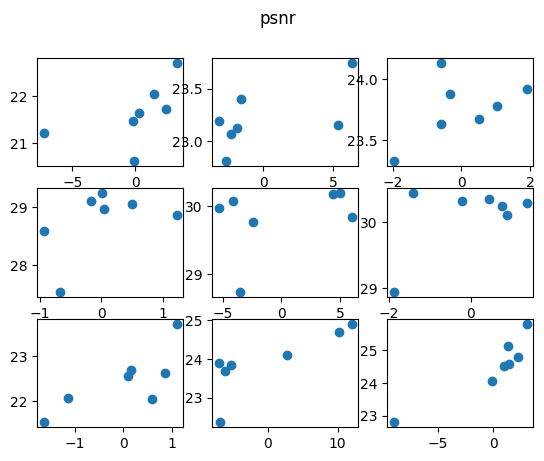

In [52]:
plot_quality_metric_against_jod_by_facet()
df_psnr = create_correlation_dataframe_by_facet()

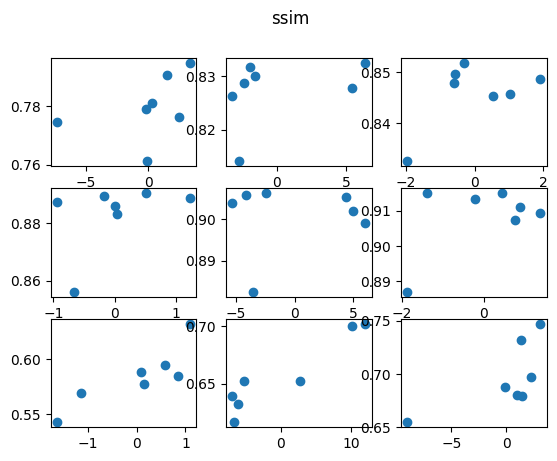

In [53]:
plot_quality_metric_against_jod_by_facet("ssim")
df_ssim = create_correlation_dataframe_by_facet("ssim")

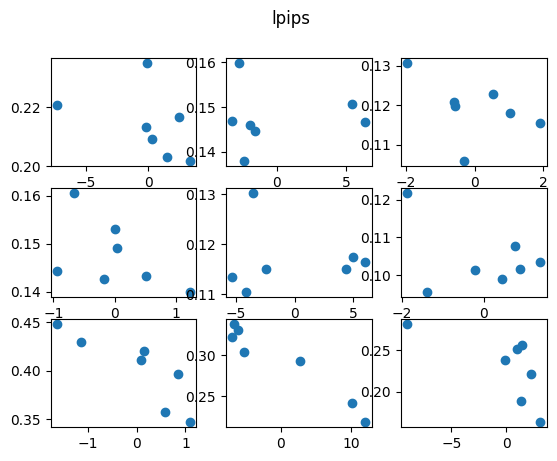

In [54]:
plot_quality_metric_against_jod_by_facet("lpips")
df_lpips = create_correlation_dataframe_by_facet("lpips")

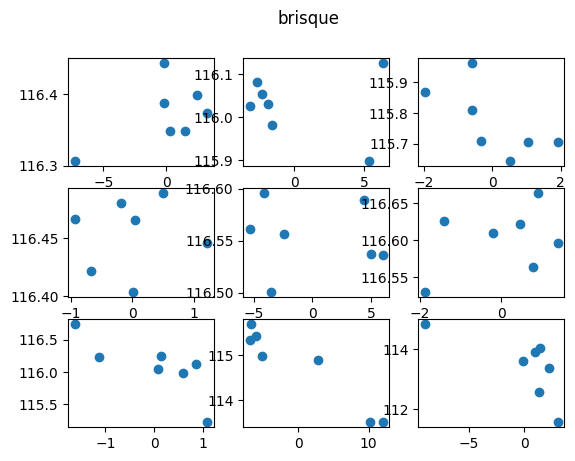

In [55]:
plot_quality_metric_against_jod_by_facet("brisque")
df_brisque = create_correlation_dataframe_by_facet("brisque")

### Heatmap - Facet by Facet


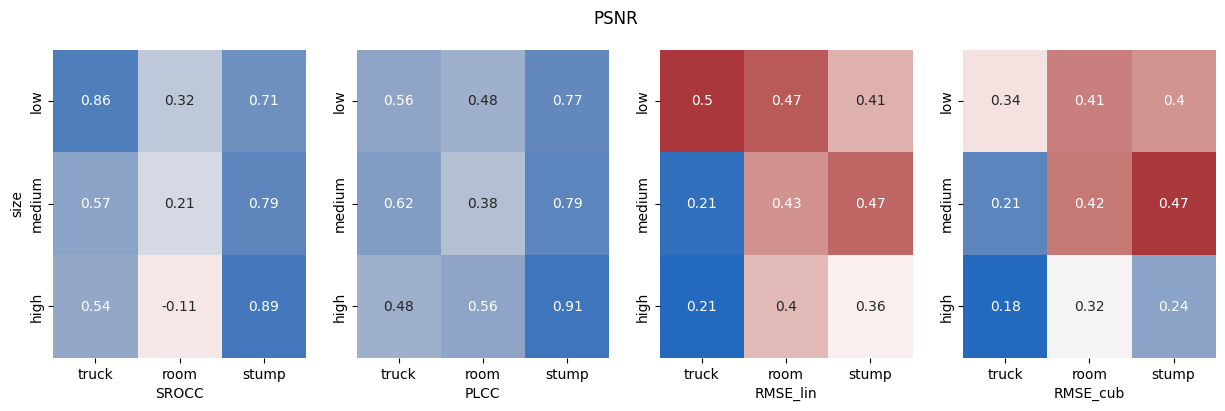

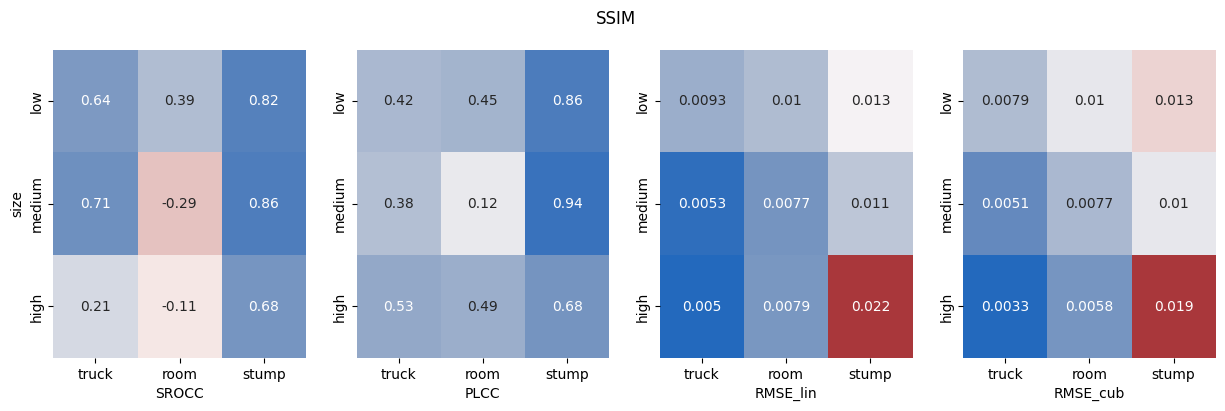

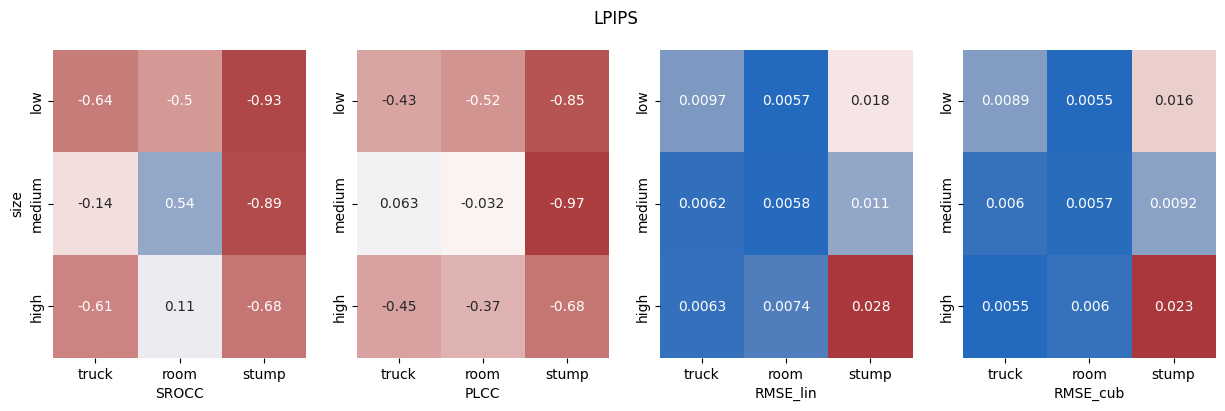

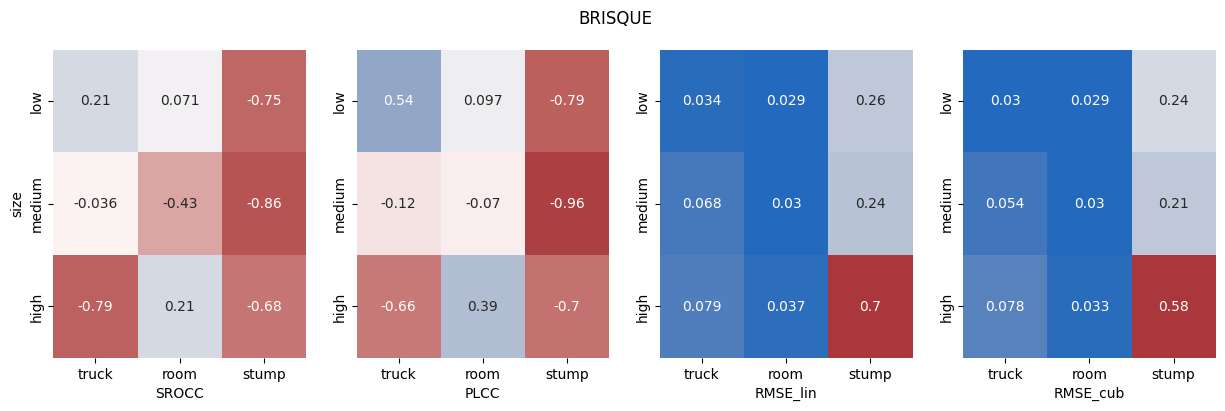

In [56]:
import seaborn as sns


def plot_heatmap_for_metrics(dataframe: pd.DataFrame, title: str):
    metrics = ["SROCC", "PLCC", "RMSE_lin", "RMSE_cub"]

    fig, axs = plt.subplots(1, len(metrics), figsize=(15, 4))

    for i, metric in enumerate(metrics):
        df_pivot = dataframe[[metric, "size", "dataset"]]
        df_pivot = pd.pivot(
            df_pivot, columns=["dataset"], index=["size"], values=[metric]
        )
        df_pivot.columns = df_pivot.columns.map(lambda x: x[1])
        df_pivot.index = pd.CategoricalIndex(
            df_pivot.index, categories=["low", "medium", "high"], ordered=True
        )
        df_pivot.sort_index(inplace=True)
        cmap = sns.color_palette("vlag", as_cmap=True).reversed()
        if "RMSE" in metric:
            cmap = cmap.reversed()
        sns.heatmap(
            df_pivot[["truck", "room", "stump"]],
            annot=True,
            ax=axs[i],
            cbar=False,
            cmap=cmap,
            vmin=None if "RMSE" in metric else -1,
            vmax=None if "RMSE" in metric else 1,
        )
        axs[i].set_xlabel(metric)
        if i > 0:
            axs[i].set_ylabel("")

    fig.suptitle(title)
    plt.show()


plot_heatmap_for_metrics(df_psnr, "PSNR")
plot_heatmap_for_metrics(df_ssim, "SSIM")
plot_heatmap_for_metrics(df_lpips, "LPIPS")
plot_heatmap_for_metrics(df_brisque, "BRISQUE")

### Scatterplot - Correlation/ No facets


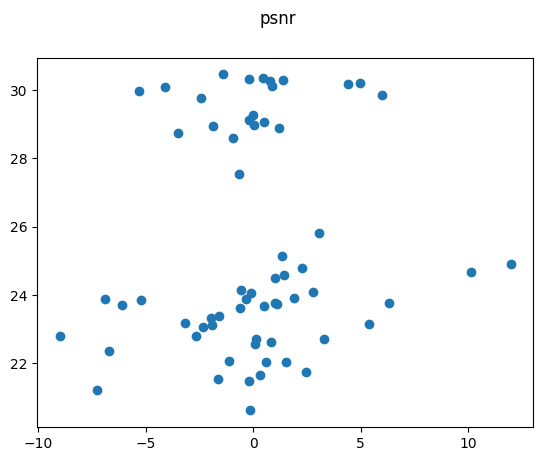

In [57]:
plot_quality_metric_against_jod("psnr")

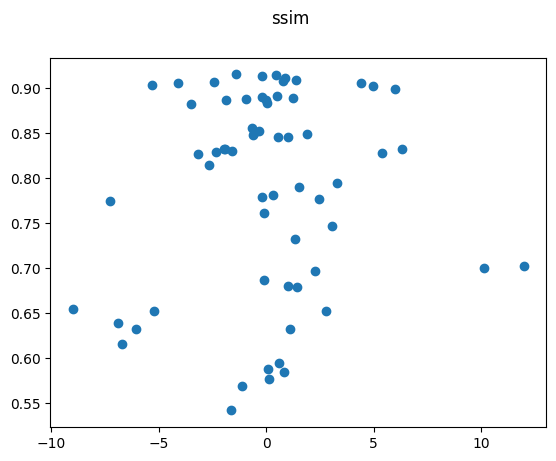

In [58]:
plot_quality_metric_against_jod("ssim")

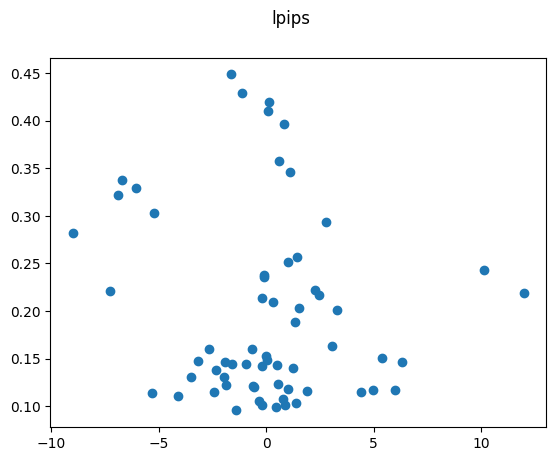

In [59]:
plot_quality_metric_against_jod("lpips")

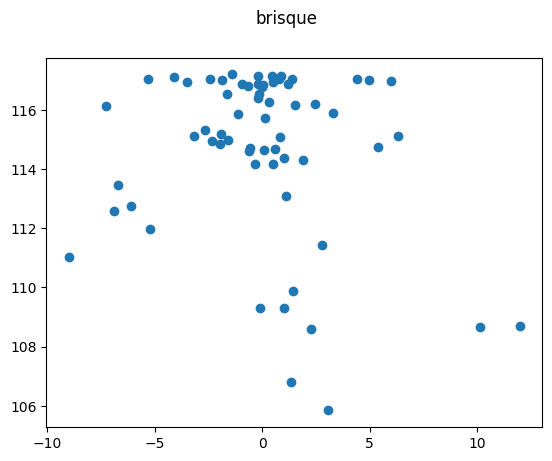

In [60]:
plot_quality_metric_against_jod("brisque")

### Cross Validation


In [61]:
jod_cv_10 = pd.read_excel("data/jod_k_fold_10.xlsx").rename(rename_jod, axis=1)

### Facet Correlation CV


In [62]:
from sklearn.model_selection import KFold


def compute_cv_correlation_analysis(jod_cv_df: pd.DataFrame) -> pd.DataFrame:
    K = jod_cv_df["fold_idx"].max() + 1

    records = []

    for dataset in ["room", "stump", "truck"]:
        for size in ["low", "medium", "high"]:
            for quality_metric in ["psnr", "ssim", "lpips", "brisque"]:
                kf = KFold(n_splits=K, shuffle=True, random_state=42)

                facet_metrics = df_metrics[
                    (df_metrics["size"] == size) & (df_metrics["dataset"] == dataset)
                ]
                for fold_idx, (train_idx, test_idx) in enumerate(
                    kf.split(facet_metrics)
                ):
                    fold_metrics = facet_metrics.iloc[train_idx]
                    fold_jod = jod_cv_df[
                        (jod_cv_df["dataset"] == dataset)
                        & (jod_cv_df["size"] == size)
                        & (jod_cv_df["fold_idx"] == fold_idx)
                    ]
                    df_agg_metrics = aggregate_metrics_by_facet(
                        facet_metrics, quality_metric, dataset, size
                    )
                    df_agg_metrics = df_agg_metrics.join(
                        fold_jod.transpose().iloc[4:].rename(lambda x: "jod", axis=1)
                    )
                    records.append(
                        {
                            "metric": quality_metric,
                            "dataset": dataset,
                            "size": size,
                            "fold_idx": fold_idx,
                            "SROCC": compute_spearman(
                                df_agg_metrics["jod"], df_agg_metrics[quality_metric]
                            ),
                            "PLCC": compute_pearsonr(
                                df_agg_metrics["jod"].astype(np.float32),
                                df_agg_metrics[quality_metric].astype(np.float32),
                            ),
                        }
                    )
    return pd.DataFrame.from_records(records)


# df_cv_10 = compute_cv_correlation_analysis(jod_cv_10)

In [63]:
import seaborn as sns


def plot_cv_results(
    df_cv: pd.DataFrame,
    corr_measure: str = "PLCC",
    metric: str = "psnr",
    ax: plt.Axes = None,
) -> None:
    K = df_cv["fold_idx"].max() + 1
    df_cv_plot = df_cv.copy()[df_cv["metric"] == metric]
    df_cv_plot["facet"] = df_cv_plot[["dataset", "size"]].apply(
        lambda row: f"{row.iloc[0]}-{row.iloc[1]}", axis=1
    )

    if ax is None:
        plt.figure(figsize=(7, 5))
    sns.violinplot(df_cv_plot, x="facet", y=corr_measure, hue="dataset", ax=ax)
    ax.get_legend().remove()
    if ax is None:
        plt.suptitle(f"Correlation JOD vs. {metric.upper()}")
        plt.xticks(rotation=90)
        plt.show()
    else:
        ax.set_title(f"Correlation JOD vs. {metric.upper()}")
        ax.set_xticks(ax.get_xticks(), ["low", "medium", "high"] * 3)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        ax.set_xlabel("Size")
        ax.grid(axis="y")
        ax.set_axisbelow(True)

#### Violinplots - 10 Fold CV


In [64]:
def plot_cv_results_full(
    df_cv: pd.DataFrame, metrics=["ssim", "psnr", "lpips", "brisque"]
) -> None:
    fig, axs = plt.subplots(len(metrics), 1, figsize=(7, 3 * len(metrics)))
    for idx_c, corr_measure in enumerate(["SROCC"]):
        for idx_m, metric in enumerate(metrics):
            plot_cv_results(df_cv, corr_measure, metric, ax=axs[idx_m])
    fig.legend(handles=axs[0].patches, loc="center left", bbox_to_anchor=(1.0, 0.5))
    plt.tight_layout()

In [65]:
# plot_cv_results_full(df_cv_10)

#### Violinplots - 20 Fold CV


In [66]:
jod_cv_20 = pd.read_excel("data/jod_k_fold_20.xlsx").rename(rename_jod, axis=1)
df_cv_20 = compute_cv_correlation_analysis(jod_cv_20)

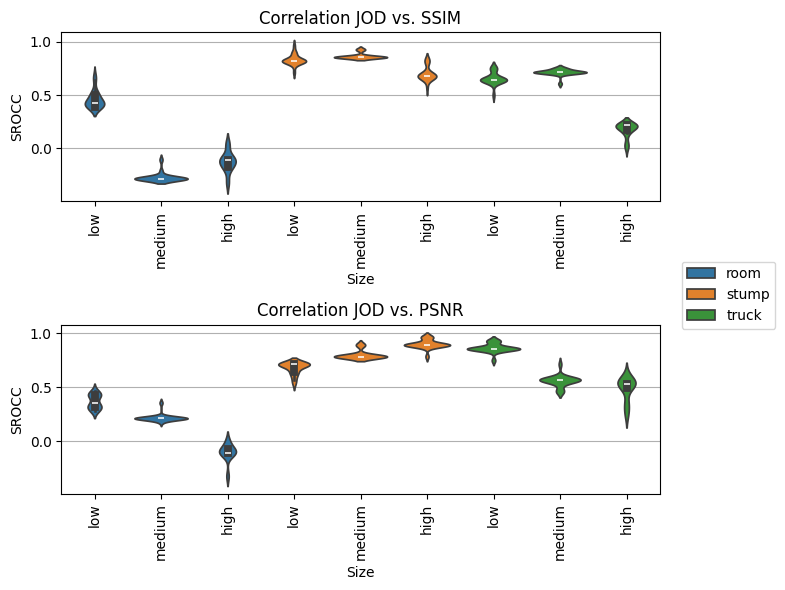

In [67]:
plot_cv_results_full(df_cv_20, metrics=["ssim", "psnr"])
plt.savefig(
    "/home/paul/TUWien/MasterThesisNerf/thesis-document/graphics/results/joint/objective-subjective-correlation.png",
    bbox_inches="tight",
    pad_inches=0.1,
)

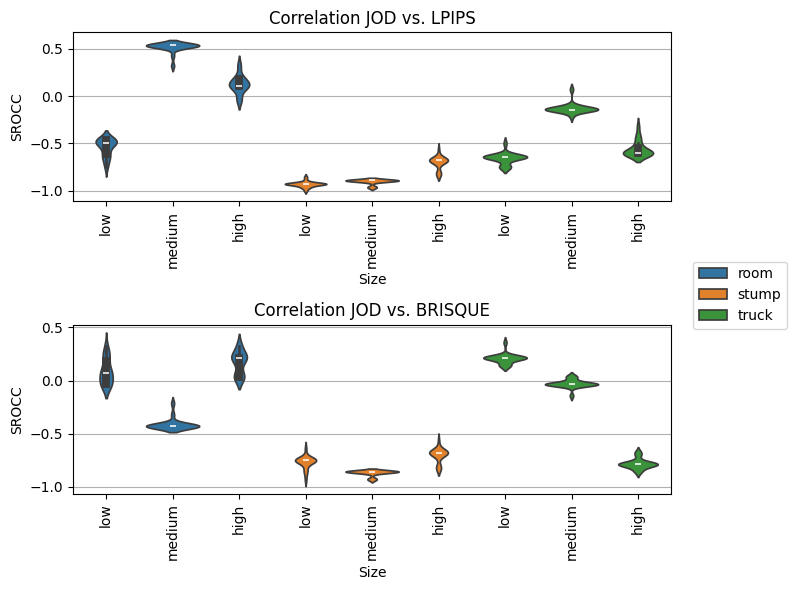

In [68]:
plot_cv_results_full(df_cv_20, metrics=["lpips", "brisque"])
plt.savefig(
    "/home/paul/TUWien/MasterThesisNerf/thesis-document/graphics/appendix/objective-subjective-correlation-rest.png",
    bbox_inches="tight",
    pad_inches=0.1,
)

### Method Correlation CV


In [69]:
df_metrics

Unnamed: 0          model dataset  size  view_idx       psnr      ssim  \
0              0        Default   truck   low         0  22.855754  0.790516   
1              1        Default   truck   low         1  22.089314  0.785142   
2              2        Default   truck   low         2  20.998716  0.745340   
3              3        Default   truck   low         3  22.494924  0.799900   
4              4        Default   truck   low         4  23.065743  0.815673   
...          ...            ...     ...   ...       ...        ...       ...   
1822        1822  Mip-Splatting   stump  high        11  26.102133  0.743162   
1823        1823  Mip-Splatting   stump  high        12  26.311471  0.789607   
1824        1824  Mip-Splatting   stump  high        13  25.426731  0.721831   
1825        1825  Mip-Splatting   stump  high        14  26.387055  0.786564   
1826        1826  Mip-Splatting   stump  high        15  25.235314  0.699294   

         lpips     brisque   brisque_0   brisque_1   brisque_2   brisque_3  \
0     0.226081  115.171990  116.147864  116.098278  116.114213  116.074353   
1     0.229413  115.158895  116.136006  116.123840  116.508714  117.497744   
2     0.237463  115.217585  116.144365  117.091111  117.609785  116.612140   
3     0.165688  116.012239  116.130337  116.708759  116.163480  116.208670   
4     0.170478  116.626857  116.229575  116.107249  116.608924  116.607607   
...        ...         ...         ...         ...         ...         ...   
1822  0.182535  105.694270  111.046030  117.388833  116.152067  118.072220   
1823  0.148849  101.186897  111.555450  114.959947  104.181276  103.505230   
1824  0.187944  104.223245  117.868110  117.553871  118.290946  116.931838   
1825  0.147307  101.425684  111.830349  118.670923  116.493008  104.801556   
1826  0.204613  106.686369  114.200930  116.492450  118.228195  109.996240   

       brisque_4  
0     116.670283  
1     115.980885  
2     115.783383  
3     116.130574  
4     116.893457  
...          ...  
1822  117.910451  
1823  117.035761  
1824  112.605944  
1825  117.000088  
1826  116.116521  

[1827 rows x 14 columns]

In [70]:
df_jod_cv_20

Unnamed: 0  size dataset  fold_idx   Default      MCMC  Mini-Splatting  \
0             0   low    room         0  1.768779  0.272103       -0.311784   
1             1   low    room         1  1.312686  0.045694        0.207886   
2             2   low    room         2  1.252760 -0.258412        0.012632   
3             3   low    room         3  1.144164  0.051849        0.009823   
4             4   low    room         4  1.506414  0.005924        0.010334   
..          ...   ...     ...       ...       ...       ...             ...   
175         175  high   truck        15 -0.581348 -0.430886       -0.311576   
176         176  high   truck        16  0.050276  0.623271        0.378886   
177         177  high   truck        17 -0.598654 -0.688189       -0.703862   
178         178  high   truck        18 -0.356591 -1.345741       -0.009200   
179         179  high   truck        19 -0.583647 -0.556784       -0.297756   

       EAGLES  Mip-Splatting  Gaussian-Pro  Geo-Gaussian  
0   -1.244932       0.540271     -0.262887     -0.761549  
1   -1.379588       0.860618     -0.376107     -0.671182  
2   -0.933280       0.362009      0.120224     -0.555937  
3   -0.926181       0.501579     -0.115509     -0.665725  
4   -0.951396       0.206201     -0.182962     -0.594518  
..        ...            ...           ...           ...  
175  1.837878       0.393985      0.995497     -1.903549  
176  2.621602       1.257902      1.771347     -6.703305  
177  2.077047       0.944845      1.048118     -2.079309  
178  2.062174       0.657146      1.165012     -2.172805  
179  1.668705       0.521776      1.187492     -1.939791  

[180 rows x 11 columns]

In [71]:
from sklearn.model_selection import KFold


def compute_cv_correlation_analysis_method(jod_cv_df: pd.DataFrame) -> pd.DataFrame:
    K = jod_cv_df["fold_idx"].max() + 1

    records = []

    for method in df_metrics["model"].unique():
        for quality_metric in ["psnr", "ssim", "lpips", "brisque"]:
            kf = KFold(n_splits=K, shuffle=True, random_state=42)

            method_metrics = df_metrics[(df_metrics["model"] == method)]
            for fold_idx, (train_idx, test_idx) in enumerate(kf.split(method_metrics)):
                if quality_metric == "brisque":
                    fold_metrics = (
                        method_metrics.iloc[train_idx]
                        .melt(
                            id_vars=["dataset", "size"],
                            value_vars=[
                                "brisque",
                                "brisque_0",
                                "brisque_1",
                                "brisque_2",
                                "brisque_3",
                                "brisque_4",
                            ],
                        )
                        .groupby(["dataset", "size"])[["value"]]
                        .mean()
                        .rename(lambda _: "brisque", axis=1)
                    )
                else:
                    fold_metrics = (
                        method_metrics.iloc[train_idx]
                        .groupby(["dataset", "size"])[quality_metric]
                        .mean()
                    )
                fold_jod = (
                    jod_cv_df[jod_cv_df["fold_idx"] == fold_idx][
                        ["dataset", "size", method]
                    ]
                    .set_index(["dataset", "size"])
                    .rename(lambda _: "jod", axis=1)
                )
                joined_fold = fold_jod.join(fold_metrics)

                records.append(
                    {
                        "metric": quality_metric,
                        "method": method,
                        "fold_idx": fold_idx,
                        "SROCC": compute_spearman(
                            joined_fold["jod"], joined_fold[quality_metric]
                        ),
                        "PLCC": compute_pearsonr(
                            joined_fold["jod"].astype(np.float32),
                            joined_fold[quality_metric].astype(np.float32),
                        ),
                    }
                )
    return pd.DataFrame.from_records(records)

#### Violinplot - 10 Fold CV


In [72]:
df_method_cv_10 = compute_cv_correlation_analysis_method(jod_cv_10)

In [73]:
def plot_method_corr_violin(
    df_cv: pd.DataFrame, metric: str, corr_measure: str, ax: plt.Axes
) -> None:
    df_constrained = df_cv[df_cv["metric"] == metric]
    K = int(df_constrained.shape[0] / 7)
    sns.violinplot(
        df_constrained,
        x="method",
        y=corr_measure,
        order=df_constrained.groupby("method")[corr_measure]
        .mean()
        .sort_values(ascending=False)
        .index,
        hue_order=hue_order,
        hue="method",
        ax=ax,
    )
    ax.set_title(f"Correlation ({corr_measure}) {K}-Fold CV - JOD vs. {metric.upper()}")
    ax.tick_params(labelrotation=90)
    ax.grid(axis="y")
    ax.set_axisbelow(True)

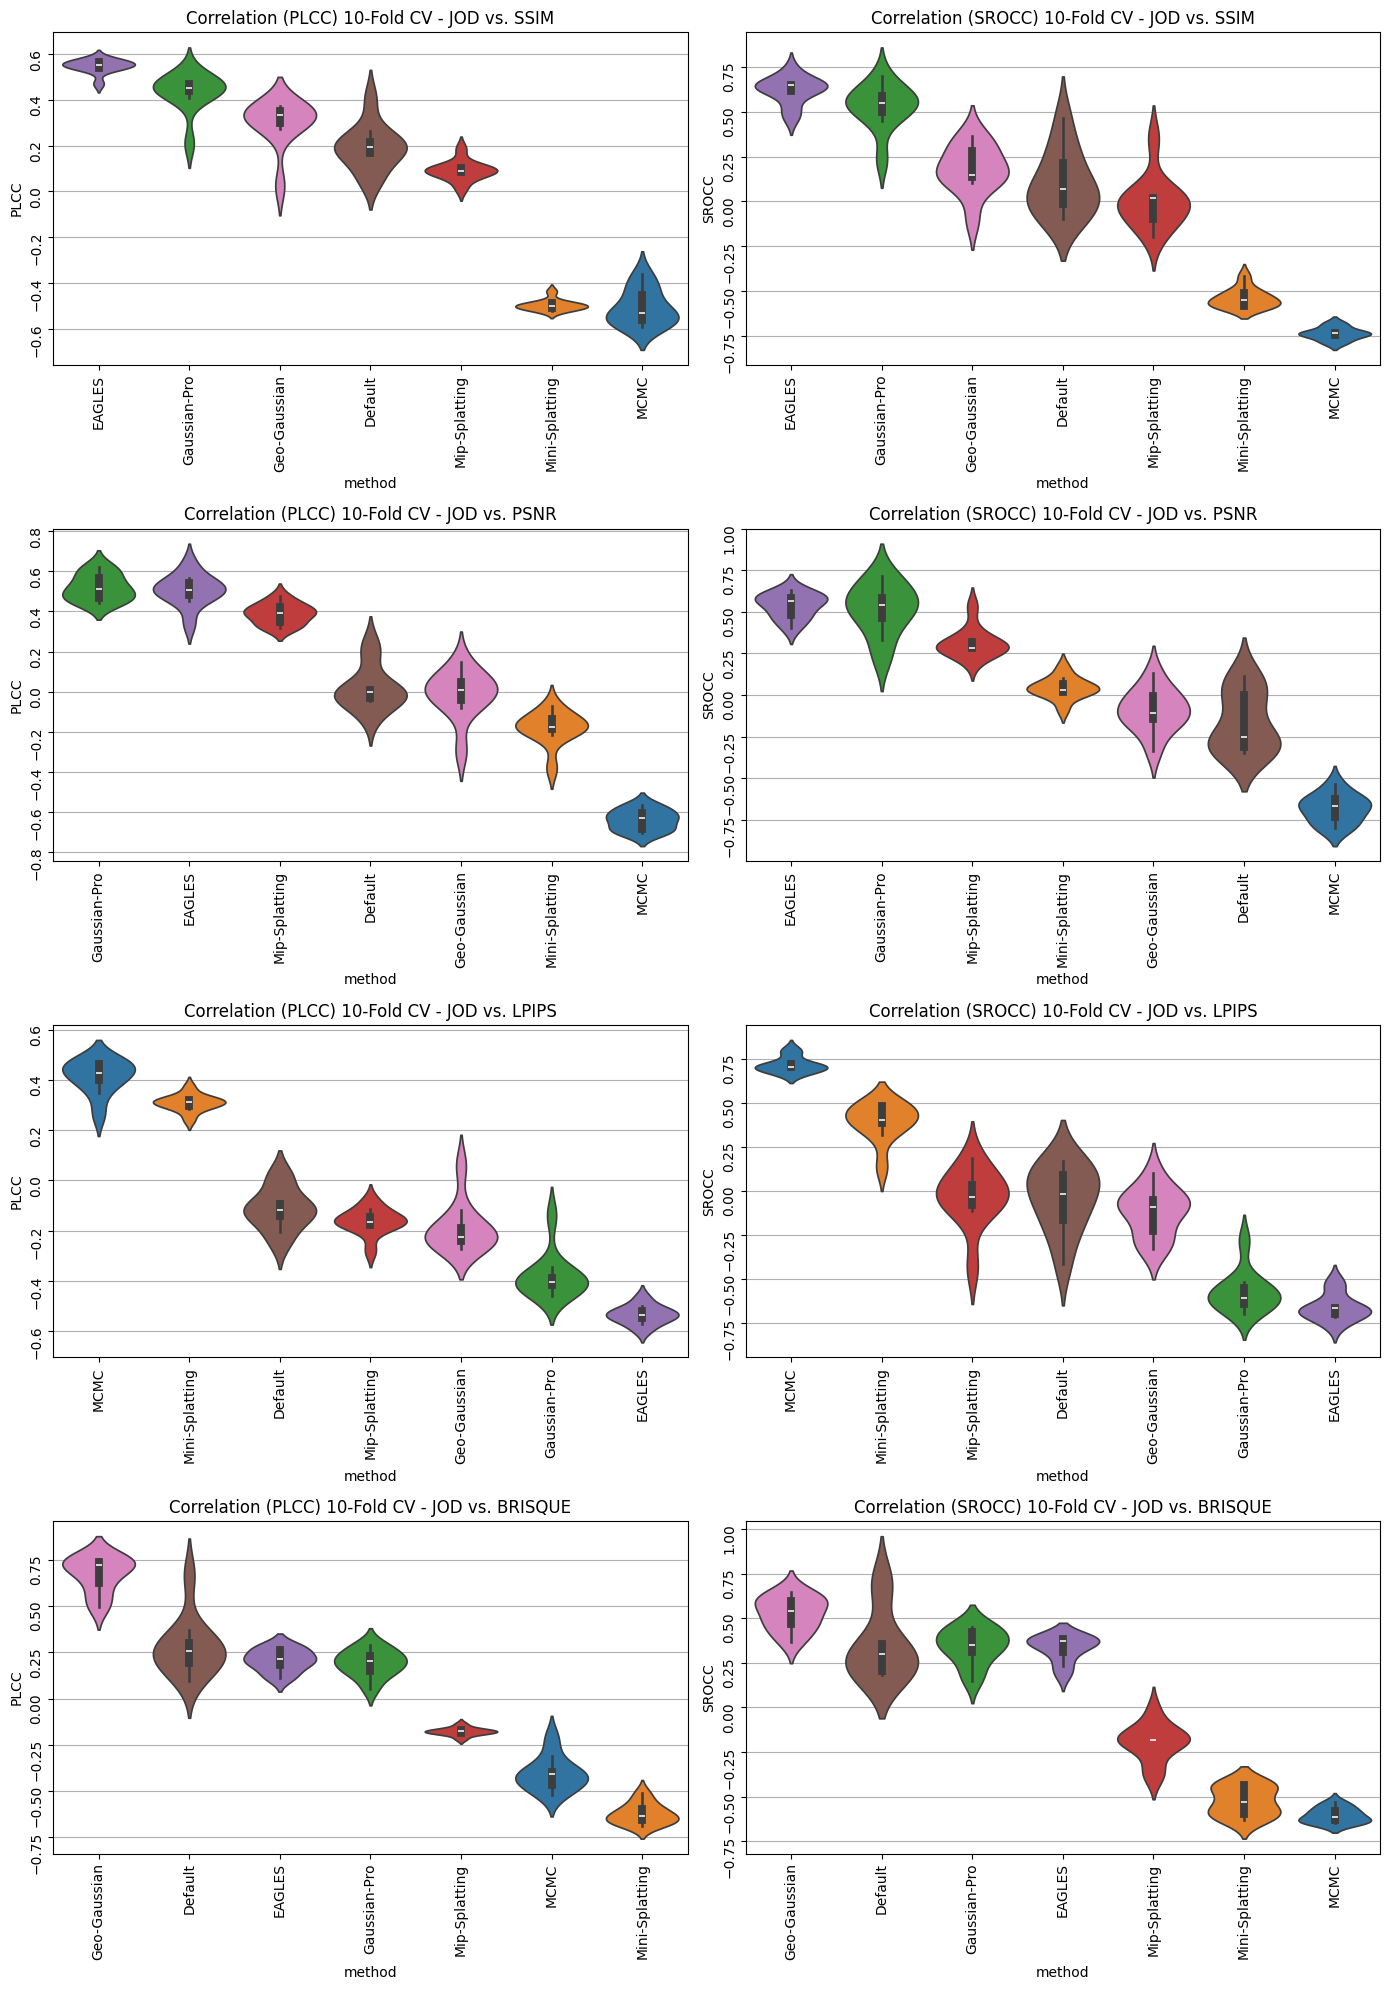

In [74]:
fig, axs = plt.subplots(4, 2, figsize=(14, 20))

for idx_c, corr_measure in enumerate(["PLCC", "SROCC"]):
    for idx_m, metric in enumerate(["ssim", "psnr", "lpips", "brisque"]):
        plot_method_corr_violin(
            df_method_cv_10, metric, corr_measure, axs[idx_m][idx_c]
        )
plt.tight_layout()
plt.show()

#### Violinplot - 20 Fold CV


In [75]:
df_method_cv_20 = compute_cv_correlation_analysis_method(jod_cv_20)

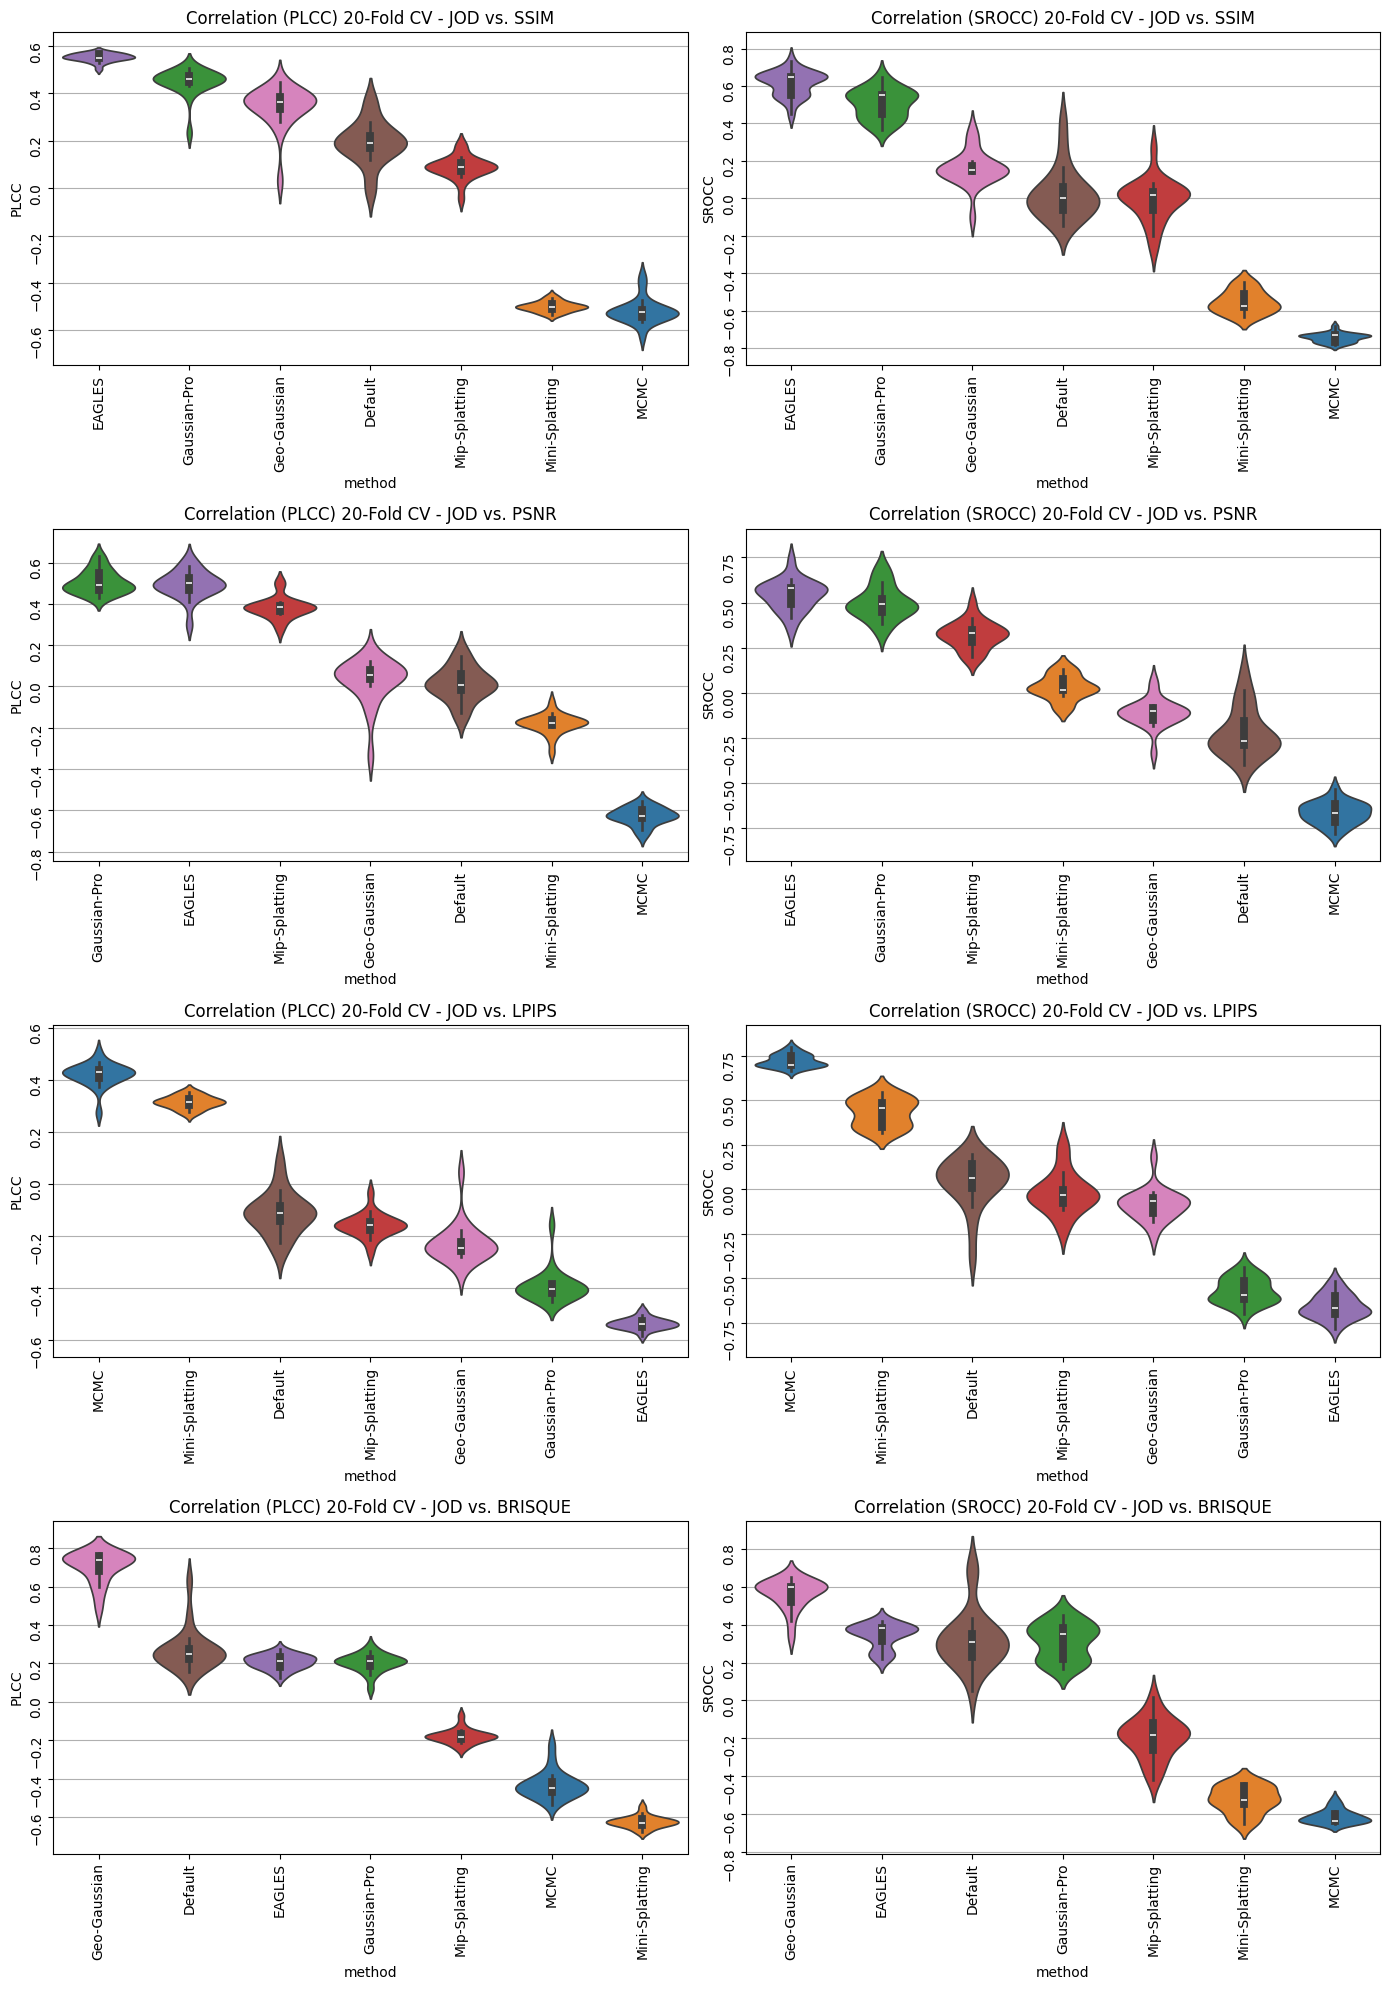

In [76]:
fig, axs = plt.subplots(4, 2, figsize=(14, 20))

for idx_c, corr_measure in enumerate(["PLCC", "SROCC"]):
    for idx_m, metric in enumerate(["ssim", "psnr", "lpips", "brisque"]):
        plot_method_corr_violin(
            df_method_cv_20, metric, corr_measure, axs[idx_m][idx_c]
        )
plt.tight_layout()
plt.show()

### Partial Least Squares


In [77]:
def melt_jod(df_jod: pd.DataFrame) -> pd.DataFrame:
    data = (
        df_jod.copy()
        .melt(
            id_vars=["size", "dataset", "fold_idx"],
            value_vars=[
                "default",
                "mcmc",
                "mini_splatting",
                "eagles",
                "mip_splatting",
                "gaussian_pro",
                "geo_gaussian",
            ],
        )
        .rename({"variable": "model", "value": "jod"}, axis=1)
    )
    data["model"] = data["model"]
    data = data.set_index(["model", "dataset", "size", "fold_idx"])
    return data

In [78]:
jod_cv_10_melt = melt_jod(jod_cv_10)

KeyError: "The following id_vars or value_vars are not present in the DataFrame: ['default', 'mcmc', 'mini_splatting', 'eagles', 'mip_splatting', 'gaussian_pro', 'geo_gaussian']"

In [ ]:
jod_cv_10_rank = jod_cv_10.copy()
methods = [
    "default",
    "mcmc",
    "mini_splatting",
    "eagles",
    "mip_splatting",
    "gaussian_pro",
    "geo_gaussian",
]

jod_cv_10_rank[methods] = jod_cv_10_rank[methods].rank(axis=1, ascending=True)
jod_cv_10_rank = melt_jod(jod_cv_10_rank).rename({"jod": "rank"}, axis=1)

In [ ]:
jod_cv_10_norm = jod_cv_10.copy()
jod_min = jod_cv_10_norm[methods].min(axis=1)
jod_max = jod_cv_10_norm[methods].max(axis=1)
jod_cv_10_norm[methods] = (
    (jod_cv_10_norm[methods].transpose() - jod_min) / (jod_max - jod_min)
).transpose()
jod_cv_10_norm = melt_jod(jod_cv_10_norm).rename({"jod": "jod_norm"}, axis=1)

In [ ]:
def compute_cv_metrics(K: int) -> pd.DataFrame:
    records = []
    kf = KFold(n_splits=K, shuffle=True, random_state=42)
    data = df_metrics.copy()
    data["brisque"] = data[
        ["brisque", "brisque_0", "brisque_1", "brisque_2", "brisque_3", "brisque_4"]
    ].mean(axis=1)

    for model in data["model"].unique():
        for dataset in data["dataset"].unique():
            for size in data["size"].unique():
                df_facet = data[
                    (data["model"] == model)
                    & (data["dataset"] == dataset)
                    & (data["size"] == size)
                ]
                for fold_idx, (train_idx, test_idx) in enumerate(kf.split(df_facet)):
                    df_fold = df_facet.iloc[train_idx]

                    records.append(
                        {
                            "model": model,
                            "dataset": dataset,
                            "size": size,
                            "fold_idx": fold_idx,
                            "ssim": df_fold["ssim"].mean(),
                            "psnr": df_fold["psnr"].mean(),
                            "lpips": df_fold["lpips"].mean(),
                            "brisque": df_fold["brisque"].mean(),
                            "N": df_fold.shape[0],
                        }
                    )

    return pd.DataFrame.from_records(records)


df_metrics_cv_20 = compute_cv_metrics(10).set_index(
    ["model", "dataset", "size", "fold_idx"]
)

In [ ]:
df_pls = df_metrics_cv_20.join(jod_cv_10_melt).join(jod_cv_10_rank).join(jod_cv_10_norm)
# df_pls = df_pls.reset_index().groupby(["model", "dataset", "size"]).mean()

In [ ]:
from sklearn.cross_decomposition import PLSRegression


def compute_and_display_pls_regression(variable: str = "jod") -> None:
    pls = PLSRegression(n_components=2)
    X = df_pls[["ssim", "psnr", "lpips", "brisque"]]
    y = df_pls[variable]
    pls.fit(X, y)
    y_pred = pls.predict(X)

    print(f"RMSE: {np.sqrt(mean_squared_error(y, y_pred))}")

    sns.scatterplot(
        x=y.values,
        y=y_pred,
        hue=df_pls.reset_index()["dataset"],
        style=df_pls.reset_index()["model"],
        size=df_pls.reset_index()["size"],
    )
    plt.title(f"Predicted vs. Actual {variable.upper()}")
    plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))
    plt.xlabel(f"Actual {variable.upper()}")
    plt.ylabel(f"Predicted {variable.upper()}")
    plt.show()

    sns.scatterplot(
        x=pls.x_scores_[:, 0],
        y=pls.x_scores_[:, 1],
        hue=df_pls.reset_index()["dataset"],
        style=df_pls.reset_index()["model"],
        size=df_pls.reset_index()["size"],
    )
    plt.title("PLS in latent space")
    plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))
    plt.xlabel("First PLS component")
    plt.ylabel("Second PLS component")
    plt.show()

RMSE: 3.8799697618716356


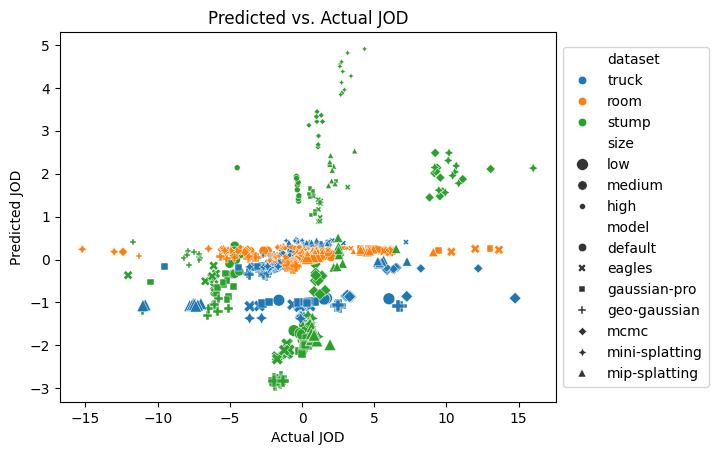

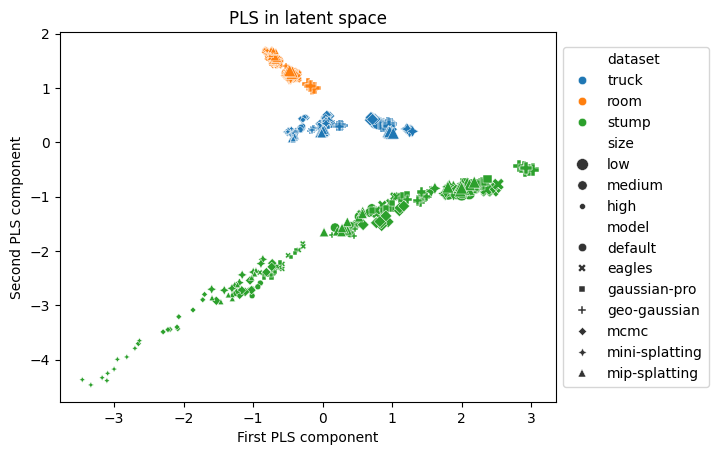

In [ ]:
compute_and_display_pls_regression()

RMSE: 1.9235056620374567


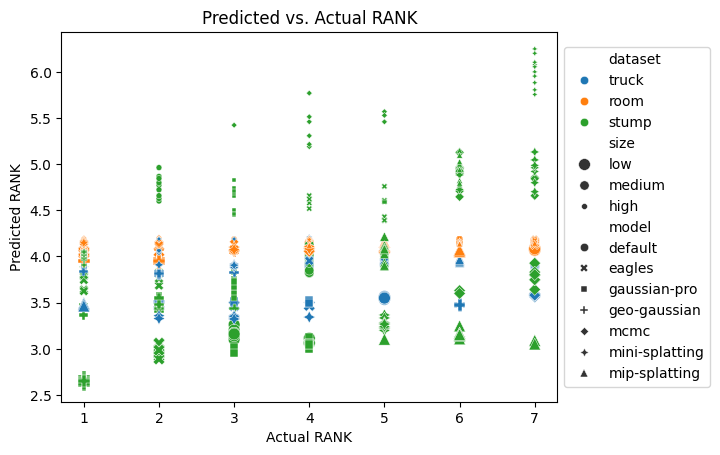

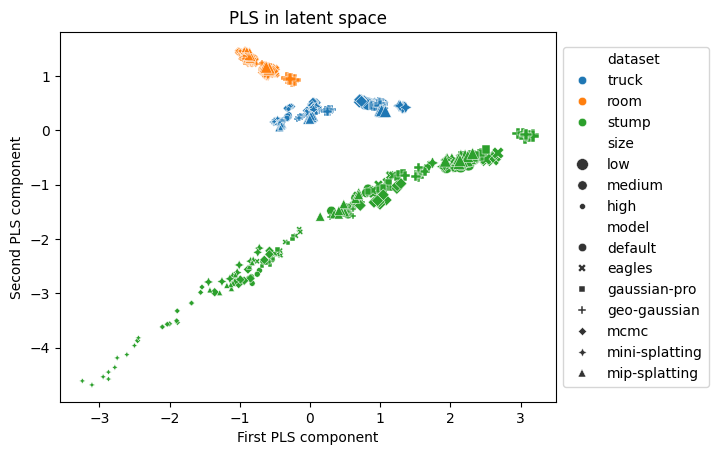

In [ ]:
compute_and_display_pls_regression("rank")

RMSE: 0.35627016647011783


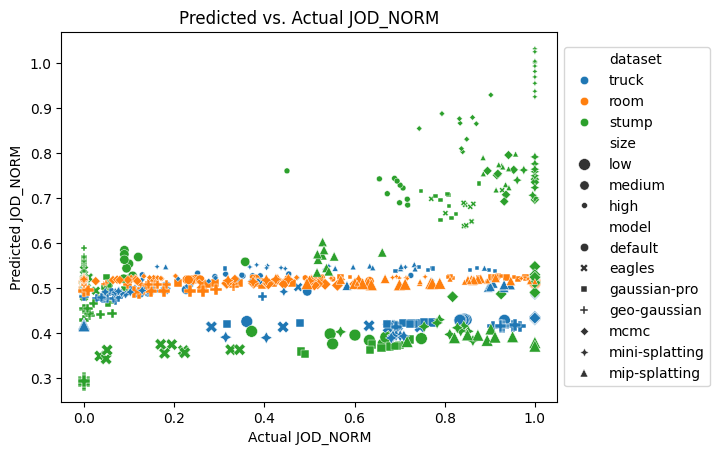

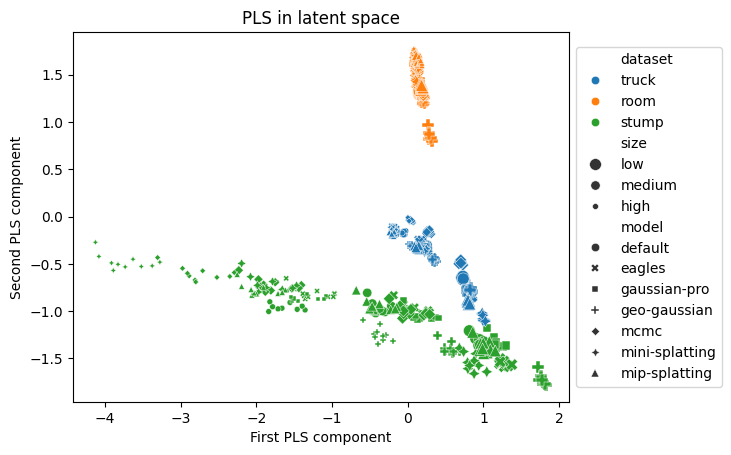

In [ ]:
compute_and_display_pls_regression("jod_norm")

In [ ]:
def compute_and_display_pls_regression_for_dataset(
    dataset: str, variable: str = "jod"
) -> None:
    pls = PLSRegression(n_components=2)
    df_pls_limited = df_pls.copy().reset_index()
    df_pls_limited = df_pls_limited[df_pls_limited["dataset"] == dataset]
    X = df_pls_limited[["ssim", "psnr", "lpips", "brisque"]]
    y = df_pls_limited[variable]
    pls.fit(X, y)
    y_pred = pls.predict(X)

    print(f"RMSE: {np.sqrt(mean_squared_error(y, y_pred))}")

    sns.scatterplot(
        x=y.values,
        y=y_pred,
        hue=df_pls_limited.reset_index()["model"],
        style=df_pls_limited.reset_index()["model"],
        size=df_pls_limited.reset_index()["size"],
    )
    plt.title(f"Predicted vs. Actual {variable.upper()} - {dataset} dataset")
    plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))
    plt.xlabel(f"Actual {variable.upper()}")
    plt.ylabel(f"Predicted {variable.upper()}")
    plt.show()

    sns.scatterplot(
        x=pls.x_scores_[:, 0],
        y=pls.x_scores_[:, 1],
        hue=df_pls_limited.reset_index()["model"],
        style=df_pls_limited.reset_index()["model"],
        size=df_pls_limited.reset_index()["size"],
    )
    plt.title("PLS in latent space")
    plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))
    plt.xlabel("First PLS component")
    plt.ylabel("Second PLS component")
    plt.show()

RMSE: 1.8332563783950084


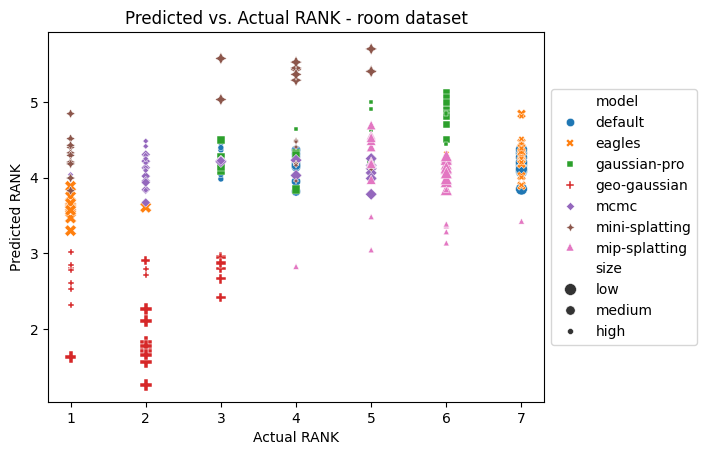

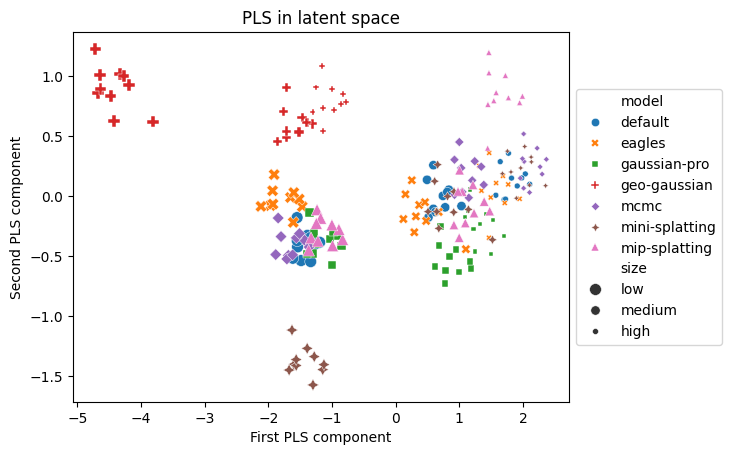

In [ ]:
compute_and_display_pls_regression_for_dataset("room", "rank")

RMSE: 1.6493538905444625


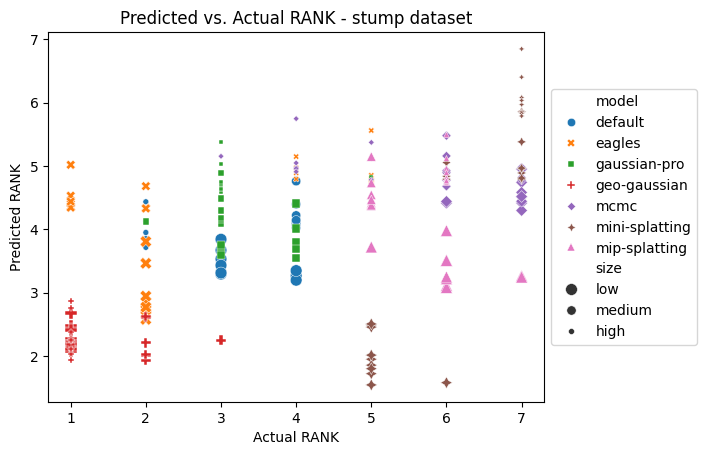

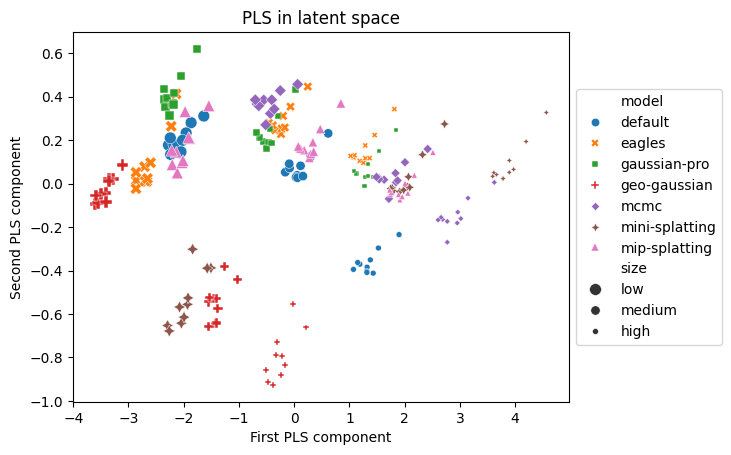

In [ ]:
compute_and_display_pls_regression_for_dataset("stump", "rank")

RMSE: 1.7582231334630847


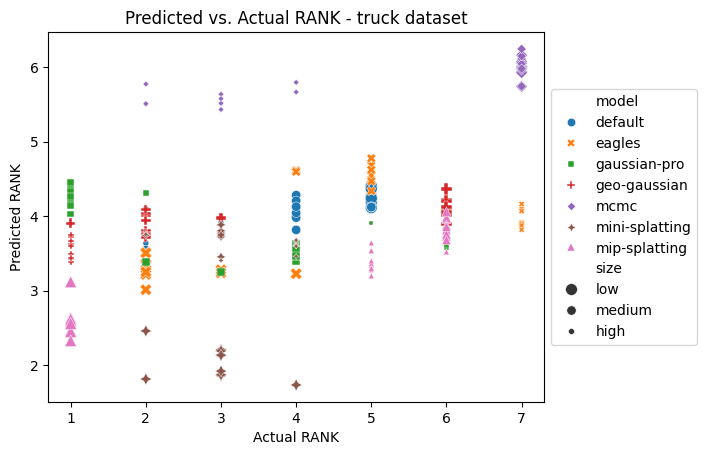

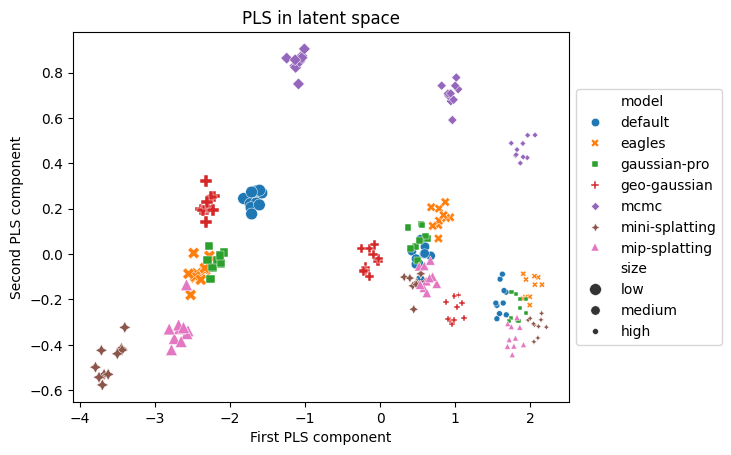

In [ ]:
compute_and_display_pls_regression_for_dataset("truck", "rank")

### Tree based rank prediction


In [ ]:
df_summary_statistics = (
    pd.read_excel("./data/summary_stats.xlsx")
    .rename({"technique": "model", "auc": "n_gaussians_auc"}, axis=1)
    .ffill()
)
df_summary_statistics["model"] = df_summary_statistics["model"]
df_summary_statistics = df_summary_statistics.set_index(["model", "dataset", "size"])

df_tree = df_pls
df_tree["rank"] = df_tree["rank"].round()
df_tree = df_tree.join(df_summary_statistics)
df_tree

ssim       psnr     lpips  \
model         dataset size fold_idx                                  
default       truck   low  0         0.793243  22.112686  0.200302   
                           1         0.786703  21.988047  0.206204   
                           2         0.789889  22.012747  0.202989   
                           3         0.791618  22.051864  0.202264   
                           4         0.789739  22.012339  0.202782   
...                                       ...        ...       ...   
mip-splatting stump   high 5         0.695254  24.697982  0.221527   
                           6         0.694451  24.704150  0.224757   
                           7         0.691022  24.676078  0.226467   
                           8         0.699131  24.839268  0.219738   
                           9         0.699542  24.780457  0.218696   

                                        brisque   N       jod  rank  jod_norm  \
model         dataset size fold_idx                                             
default       truck   low  0         116.354793  28  1.361853   5.0  0.834510   
                           1         116.357919  28 -1.611766   5.0  0.361114   
                           2         116.358006  29  1.601380   5.0  0.838948   
                           3         116.342966  29  1.694191   5.0  0.847645   
                           4         116.347786  29  1.495822   5.0  0.833361   
...                                         ...  ..       ...   ...       ...   
mip-splatting stump   high 5         113.268595  14  1.926233   6.0  0.928723   
                           6         113.740009  15  1.831363   6.0  0.913991   
                           7         113.683299  15  2.287128   6.0  0.942404   
                           8         113.431802  15  2.089357   6.0  0.885732   
                           9         113.240597  15  1.919622   6.0  0.919846   

                                     diff_to_self_psnr  diff_to_best_psnr  \
model         dataset size fold_idx                                         
default       truck   low  0                   0.00877           0.747453   
                           1                   0.00877           0.747453   
                           2                   0.00877           0.747453   
                           3                   0.00877           0.747453   
                           4                   0.00877           0.747453   
...                                                ...                ...   
mip-splatting stump   high 5                   0.00000           0.643253   
                           6                   0.00000           0.643253   
                           7                   0.00000           0.643253   
                           8                   0.00000           0.643253   
                           9                   0.00000           0.643253   

                                     diff_to_self_ssim  diff_to_best_ssim  \
model         dataset size fold_idx                                         
default       truck   low  0                  0.000317           0.005419   
                           1                  0.000317           0.005419   
                           2                  0.000317           0.005419   
                           3                  0.000317           0.005419   
                           4                  0.000317           0.005419   
...                                                ...                ...   
mip-splatting stump   high 5                  0.000000           0.053718   
                           6                  0.000000           0.053718   
                           7                  0.000000           0.053718   
                           8                  0.000000           0.053718   
                           9                  0.000000           0.053718   

                                     n_gaussians_auc  deleted_rmse  \
mo

In [ ]:
import itertools

kf = KFold(7, shuffle=True, random_state=123)

facets = np.array(
    list(
        itertools.product(
            df_tree.index.get_level_values(0).unique(),
            ["truck", "stump", "room"],
            ["low", "medium", "high"],
        )
    )
)

get_locs = df_tree.index.get_locs

for train_idx, test_idx in kf.split(df_tree.index.get_level_values(0).unique()):
    train_tuples = [get_locs(tuple(facets[i])) for i in train_idx]
    train_idxs = [idx for idxs in train_tuples for idx in idxs]
    test_tuples = [get_locs(tuple(facets[i])) for i in test_idx]
    test_idxs = [idx for idxs in test_tuples for idx in idxs]

    print(train_idxs)
    print(test_idxs)
    break

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


In [ ]:
from dataclasses import dataclass
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


@dataclass
class RandomForestResult:
    df_feature_importance: pd.DataFrame
    r2: float
    rmse: float


def compute_random_forestcv(
    data: pd.DataFrame, n_estimators=1000
) -> RandomForestResult:
    X = data.drop(
        columns=[
            "N",
            "jod",
            "jod_norm",
            "rank",
            "diff_to_best_psnr",
            "diff_to_best_ssim",
        ]
    )
    y = data["jod_norm"]

    feature_importances = []
    rmse_scores = []
    r2_scores = []

    kf = KFold(20, shuffle=True, random_state=42)

    get_locs = df_tree.index.get_locs

    for technique in df_tree.index.get_level_values(0).unique():
        # train_tuples = [get_locs(tuple(facets[i])) for i in train_idx]
        # train_idx = [idx for idxs in train_tuples for idx in idxs]
        # test_tuples = [get_locs(tuple(facets[i])) for i in test_idx]
        # test_idx = [idx for idxs in test_tuples for idx in idxs]
        other_techniques = [
            t for t in df_tree.index.get_level_values(0).unique() if t != technique
        ]

        X_train, X_test = X.loc[other_techniques], X.loc[technique]
        y_train, y_test = y.loc[other_techniques], y.loc[technique]

        model = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
        r2_scores.append(r2_score(y_test, y_pred))

        feature_importances.append(model.feature_importances_)

    avg_importance = np.mean(feature_importances, axis=0)
    df_importance = pd.DataFrame.from_dict(
        {"variable": X.columns, "importance": avg_importance}
    ).sort_values("importance", ascending=False)

    return RandomForestResult(df_importance, np.mean(r2_scores), np.mean(rmse_scores))

In [ ]:
full_tree_result = compute_random_forestcv(df_tree, n_estimators=100)

print("Mean RMSE:", full_tree_result.rmse)
print("Mean R² Score:", full_tree_result.r2)

Mean RMSE: 0.4278851592257978
Mean R² Score: -0.7832942686101829


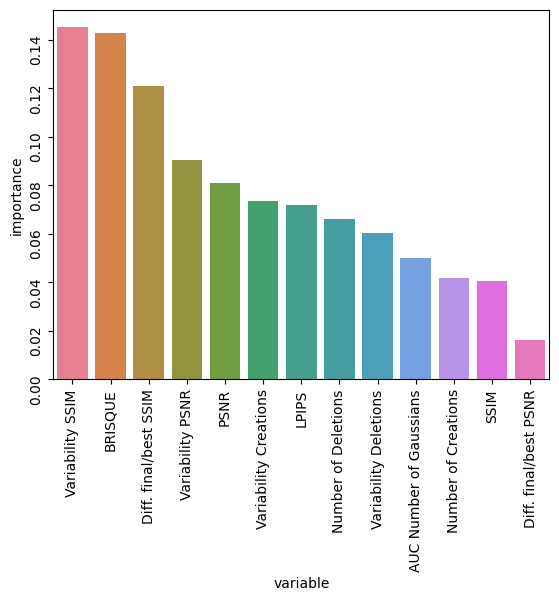

In [ ]:
display_names = {
    "diff_to_self_psnr": "Diff. final/best PSNR",
    "diff_to_self_ssim": "Diff. final/best SSIM",
    "test_ssim_rmse": "Variability SSIM",
    "test_psnr_rmse": "Variability PSNR",
    "lpips": "LPIPS",
    "n_gaussians_auc": "AUC Number of Gaussians",
    "deleted_rmse": "Variability Deletions",
    "cumulative_creations": "Number of Creations",
    "psnr": "PSNR",
    "brisque": "BRISQUE",
    "created_rmse": "Variability Creations",
    "ssim": "SSIM",
    "cumulative_deletions": "Number of Deletions",
}


def plot_feature_importance(df_feature_importance: pd.DataFrame) -> None:
    data = df_feature_importance.copy()
    data["variable"] = data["variable"].apply(lambda v: display_names[v])
    sns.barplot(data, x="variable", y="importance", hue="variable")
    plt.tick_params(labelrotation=90)


plot_feature_importance(full_tree_result.df_feature_importance)

Mean RMSE: 0.35829298241367313
Mean R² Score: -63.53558488510792


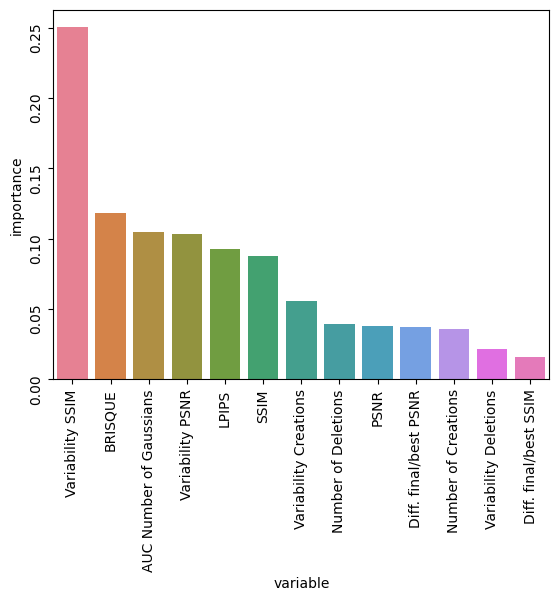

In [ ]:
dataset = "stump"
full_limited_result = compute_random_forestcv(
    df_tree.loc[:, dataset, :], n_estimators=100
)

print("Mean RMSE:", full_limited_result.rmse)
print("Mean R² Score:", full_limited_result.r2)
plot_feature_importance(full_limited_result.df_feature_importance)

### Violinplot - JOD Variability


In [ ]:
jod_cv_20

Unnamed: 0  size dataset  fold_idx   default      mcmc  mini_splatting  \
0             0   low    room         0  1.768779  0.272103       -0.311784   
1             1   low    room         1  1.312686  0.045694        0.207886   
2             2   low    room         2  1.252760 -0.258412        0.012632   
3             3   low    room         3  1.144164  0.051849        0.009823   
4             4   low    room         4  1.506414  0.005924        0.010334   
..          ...   ...     ...       ...       ...       ...             ...   
175         175  high   truck        15 -0.581348 -0.430886       -0.311576   
176         176  high   truck        16  0.050276  0.623271        0.378886   
177         177  high   truck        17 -0.598654 -0.688189       -0.703862   
178         178  high   truck        18 -0.356591 -1.345741       -0.009200   
179         179  high   truck        19 -0.583647 -0.556784       -0.297756   

       eagles  mip_splatting  gaussian_pro  geo_gaussian  
0   -1.244932       0.540271     -0.262887     -0.761549  
1   -1.379588       0.860618     -0.376107     -0.671182  
2   -0.933280       0.362009      0.120224     -0.555937  
3   -0.926181       0.501579     -0.115509     -0.665725  
4   -0.951396       0.206201     -0.182962     -0.594518  
..        ...            ...           ...           ...  
175  1.837878       0.393985      0.995497     -1.903549  
176  2.621602       1.257902      1.771347     -6.703305  
177  2.077047       0.944845      1.048118     -2.079309  
178  2.062174       0.657146      1.165012     -2.172805  
179  1.668705       0.521776      1.187492     -1.939791  

[180 rows x 11 columns]

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'room-low'),
  Text(1, 0, 'room-medium'),
  Text(2, 0, 'room-high'),
  Text(3, 0, 'stump-low'),
  Text(4, 0, 'stump-medium'),
  Text(5, 0, 'stump-high'),
  Text(6, 0, 'truck-low'),
  Text(7, 0, 'truck-medium'),
  Text(8, 0, 'truck-high')])

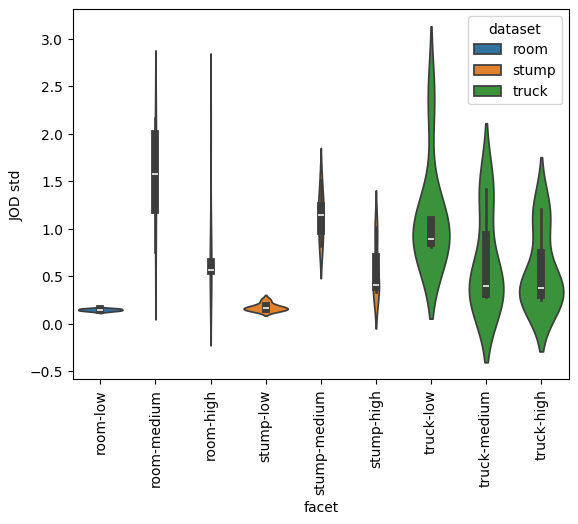

In [ ]:
jod_cv_20_facet = jod_cv_20.copy()
jod_cv_20_facet["facet"] = jod_cv_20_facet[["dataset", "size"]].apply(
    lambda row: f"{row.iloc[0]}-{row.iloc[1]}", axis=1
)
jod_cv_20_facet = (
    (jod_cv_20_facet.iloc[:, 4:].groupby(["facet"]).std())
    .reset_index()
    .melt(id_vars="facet")
    .rename({"value": "JOD std"}, axis=1)
)
jod_cv_20_facet
jod_cv_20_facet["dataset"] = jod_cv_20_facet["facet"].apply(lambda x: x.split("-")[0])
jod_cv_20_facet["size"] = jod_cv_20_facet["facet"].apply(lambda x: x.split("-")[1])


def get_key(x):
    idx = {"low": 0, "medium": 1, "high": 2}
    return f"{x.split('-')[0]}-{idx[x.split('-')[1]]}"


jod_cv_20_facet = jod_cv_20_facet.sort_values("facet", key=np.vectorize(get_key))

sns.violinplot(jod_cv_20_facet, x="facet", y="JOD std", hue="dataset")
plt.xticks(rotation=90)

### Boxplot - JOD variability


/tmp/ipykernel_8449/2623664365.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lambda x: f"{x[0]}-{x[1]}", axis=1


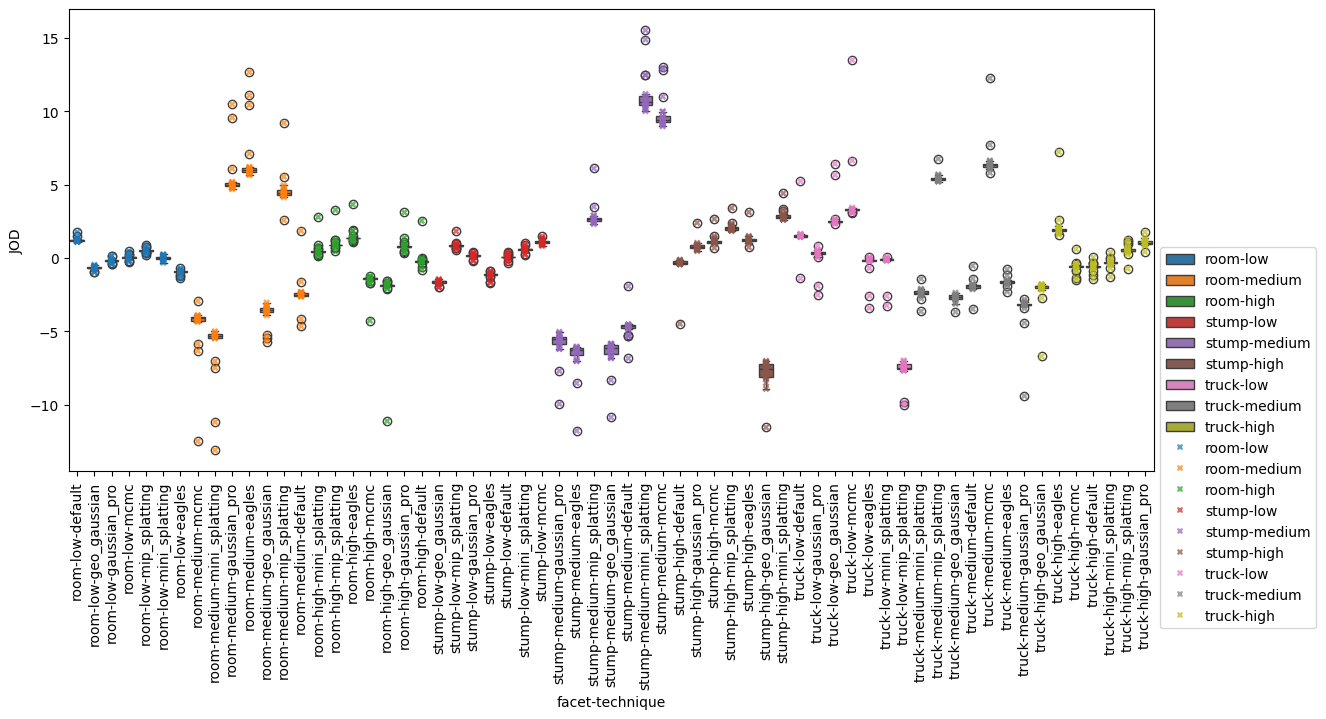

In [ ]:
jod_cv_20_facet = jod_cv_20.copy()
jod_cv_20_facet["facet"] = jod_cv_20_facet[["dataset", "size"]].apply(
    lambda row: f"{row.iloc[0]}-{row.iloc[1]}", axis=1
)
jod_cv_20_facet = (
    (jod_cv_20_facet.iloc[:, 4:])
    .melt(id_vars="facet")
    .rename({"value": "JOD", "variable": "technique"}, axis=1)
)
jod_cv_20_facet["dataset"] = jod_cv_20_facet["facet"].apply(lambda x: x.split("-")[0])
jod_cv_20_facet["size"] = jod_cv_20_facet["facet"].apply(lambda x: x.split("-")[1])
jod_cv_20_facet["facet-technique"] = jod_cv_20_facet[["facet", "technique"]].apply(
    lambda x: f"{x[0]}-{x[1]}", axis=1
)
jod_cv_20_facet


def get_key(x):
    idx = {"low": 0, "medium": 1, "high": 2}
    return f"{x.split('-')[0]}-{idx[x.split('-')[1]]}"


jod_cv_20_facet = jod_cv_20_facet.sort_values("facet", key=np.vectorize(get_key))

plt.figure(figsize=(14, 6))
ax = sns.boxplot(jod_cv_20_facet, x="facet-technique", y="JOD", hue="facet")
sns.stripplot(
    jod_cv_20_facet,
    x="facet-technique",
    y="JOD",
    hue="facet",
    marker="X",
    jitter=False,
    alpha=0.7,
)
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.0, 0.5))
plt.show()

### Congruence between wandb and cluster test measurements


In [ ]:
df_wand_test = pd.read_parquet("./data/test_statistics.parquet")
df_wand_test["_step"] = df_wand_test.index
df_wand_test

test_full/ssim  test_full/psnr dataset_name     technique  size  _step
0         0.596729       15.807237        truck          mcmc   low      0
1         0.676081       19.094009        truck          mcmc   low      1
2         0.676081       19.094009        truck          mcmc   low      2
3         0.701434       20.109855        truck          mcmc   low      3
4         0.712163       20.520590        truck          mcmc   low      4
..             ...             ...          ...           ...   ...    ...
85        0.680591       23.276541        stump  geo_gaussian  high     85
86        0.680591       23.276541        stump  geo_gaussian  high     86
87        0.679724       23.223272        stump  geo_gaussian  high     87
88        0.680399       23.259621        stump  geo_gaussian  high     88
89        0.680399       23.259621        stump  geo_gaussian  high     89

[5670 rows x 6 columns]

In [ ]:
def compute_cluster_and_wandb_congruency() -> pd.DataFrame:
    records = []
    for size in df_wand_test["size"].unique():
        for technique in df_wand_test["technique"].unique():
            for dataset in df_wand_test["dataset_name"].unique():
                wand_observation = df_wand_test[
                    (df_wand_test["_step"] == df_wand_test["_step"].max())
                    & (df_wand_test["dataset_name"] == dataset)
                    & (df_wand_test["technique"] == technique)
                    & (df_wand_test["size"] == size)
                ]
                assert len(wand_observation) == 1, wand_observation.shape
                cluster_observation = df_metrics[
                    (df_metrics["dataset"] == dataset)
                    & (df_metrics["model"] == technique)
                    & (df_metrics["size"] == size)
                ]
                records.append(
                    {
                        "technique": technique,
                        "dataset": dataset,
                        "size": size,
                        "diff_psnr": wand_observation["test_full/psnr"].iloc[-1]
                        - cluster_observation["psnr"].mean(),
                        "diff_ssim": wand_observation["test_full/ssim"].iloc[-1]
                        - cluster_observation["ssim"].mean(),
                        "name": f"{technique}-{dataset}-{size}",
                    }
                )

    return pd.DataFrame.from_records(records)

In [ ]:
incongruency = compute_cluster_and_wandb_congruency()
incongruency

technique dataset  size  diff_psnr  diff_ssim                     name
0           mcmc   truck   low   1.049840   0.017299           mcmc-truck-low
1           mcmc    room   low   2.191070   0.022012            mcmc-room-low
2           mcmc   stump   low   0.057797   0.016820           mcmc-stump-low
3        default   truck   low   0.999125   0.016853        default-truck-low
4        default    room   low   2.052811   0.019218         default-room-low
..           ...     ...   ...        ...        ...                      ...
58  gaussian_pro    room  high   1.052538   0.013386   gaussian_pro-room-high
59  gaussian_pro   stump  high   0.741047   0.022812  gaussian_pro-stump-high
60  geo_gaussian   truck  high   0.785317   0.014788  geo_gaussian-truck-high
61  geo_gaussian    room  high   1.812890   0.026506   geo_gaussian-room-high
62  geo_gaussian   stump  high   0.467994   0.026086  geo_gaussian-stump-high

[63 rows x 6 columns]

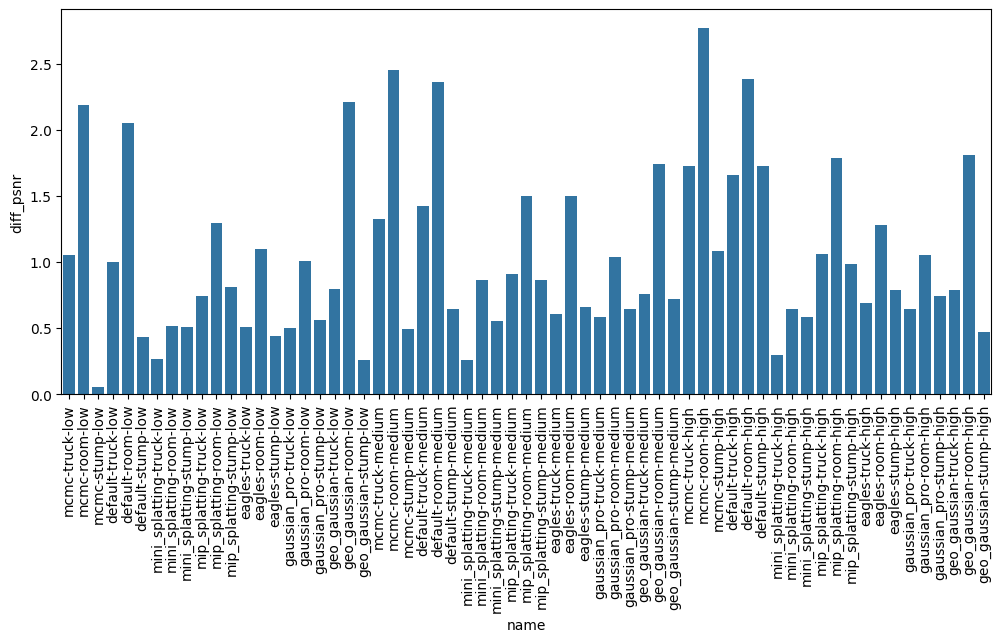

In [ ]:
plt.figure(figsize=(12, 5))
sns.barplot(incongruency, x="name", y="diff_psnr")
plt.xticks(rotation=90)
plt.show()

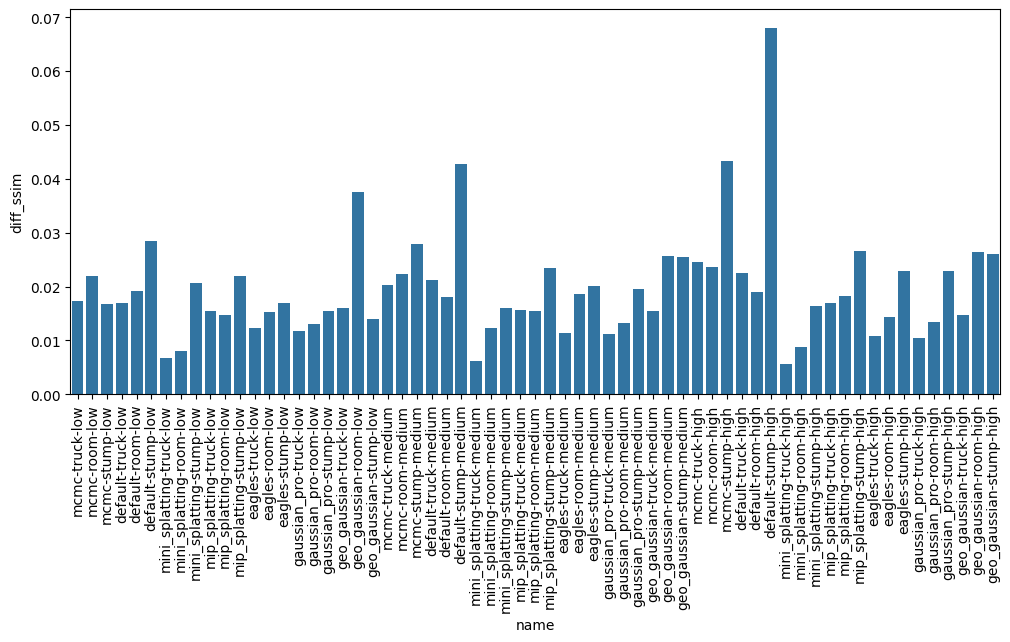

In [ ]:
plt.figure(figsize=(12, 5))
sns.barplot(incongruency, x="name", y="diff_ssim")
plt.xticks(rotation=90)
plt.show()

### How consistent is the ranking across my two different data sources?


In [ ]:
def compute_cluster_and_wandb_rank_consistency() -> pd.DataFrame:
    records = []
    for size in df_wand_test["size"].unique():
        for dataset in df_wand_test["dataset_name"].unique():
            wand_observations = df_wand_test[
                (df_wand_test["_step"] == df_wand_test["_step"].max())
                & (df_wand_test["dataset_name"] == dataset)
                & (df_wand_test["size"] == size)
            ].set_index("technique")
            assert len(wand_observations) == 7, wand_observations.shape
            cluster_observations = (
                df_metrics[
                    (df_metrics["dataset"] == dataset) & (df_metrics["size"] == size)
                ]
                .groupby("model")[["psnr", "ssim"]]
                .mean()
            )
            assert len(cluster_observations) == 7, wand_observations.shape

            record = {
                "dataset": dataset,
                "size": size,
            }
            for var_name_wand, var_name_metrics in [
                ("test_full/ssim", "ssim"),
                ("test_full/psnr", "psnr"),
            ]:
                rank_diff = (
                    wand_observations[var_name_wand].rank().sort_index()
                    - cluster_observations[var_name_metrics].rank().sort_index()
                )
                record[f"{var_name_metrics}_methods"] = rank_diff[
                    rank_diff != 0
                ].index.values
                record[f"absolute_rank_diff_{var_name_metrics}"] = rank_diff.abs().sum()

            records.append(record)

    return pd.DataFrame.from_records(records)


compute_cluster_and_wandb_rank_consistency().sort_values("absolute_rank_diff_psnr")

dataset    size                                       ssim_methods  \
0   truck     low                             [eagles, geo_gaussian]   
5   stump  medium                             [mcmc, mini_splatting]   
2   stump     low                          [default, mini_splatting]   
8   stump    high     [default, mcmc, mini_splatting, mip_splatting]   
7    room    high           [default, mini_splatting, mip_splatting]   
3   truck  medium  [default, eagles, gaussian_pro, mcmc, mini_spl...   
6   truck    high  [default, eagles, gaussian_pro, mcmc, mini_spl...   
1    room     low  [default, gaussian_pro, mcmc, mini_splatting, ...   
4    room  medium  [default, eagles, gaussian_pro, mcmc, mini_spl...   

   absolute_rank_diff_ssim                                       psnr_methods  \
0                      2.0                                                 []   
5                      2.0                                                 []   
2                      2.0  [eagles, gaussian_pro, mini_splatting, mip_spl...   
8                      4.0     [default, eagles, gaussian_pro, mip_splatting]   
7                      4.0           [default, mini_splatting, mip_splatting]   
3                      8.0  [default, eagles, gaussian_pro, geo_gaussian, ...   
6                     12.0  [default, eagles, gaussian_pro, mini_splatting...   
1                     10.0  [default, eagles, gaussian_pro, geo_gaussian, ...   
4                      6.0  [default, eagles, gaussian_pro, mcmc, mini_spl...   

   absolute_rank_diff_psnr  
0                      0.0  
5                      0.0  
2                      4.0  
8                      6.0  
7                      8.0  
3                     10.0  
6                     12.0  
1                     14.0  
4                     14.0

### Basic Tables


In [ ]:
df_jod.iloc[:, 3:].rank(axis=1).sum().sort_values(ascending=False)

Mip-Splatting     46.0
MCMC              43.0
Mini-Splatting    38.0
EAGLES            37.0
Gaussian-Pro      35.0
Default           34.0
Geo-Gaussian      19.0
dtype: float64

In [ ]:
df_metrics

Unnamed: 0          model dataset  size  view_idx       psnr      ssim  \
0              0        Default   truck   low         0  22.855754  0.790516   
1              1        Default   truck   low         1  22.089314  0.785142   
2              2        Default   truck   low         2  20.998716  0.745340   
3              3        Default   truck   low         3  22.494924  0.799900   
4              4        Default   truck   low         4  23.065743  0.815673   
...          ...            ...     ...   ...       ...        ...       ...   
1822        1822  Mip-Splatting   stump  high        11  26.102133  0.743162   
1823        1823  Mip-Splatting   stump  high        12  26.311471  0.789607   
1824        1824  Mip-Splatting   stump  high        13  25.426731  0.721831   
1825        1825  Mip-Splatting   stump  high        14  26.387055  0.786564   
1826        1826  Mip-Splatting   stump  high        15  25.235314  0.699294   

         lpips     brisque   brisque_0   brisque_1   brisque_2   brisque_3  \
0     0.226081  115.171990  116.147864  116.098278  116.114213  116.074353   
1     0.229413  115.158895  116.136006  116.123840  116.508714  117.497744   
2     0.237463  115.217585  116.144365  117.091111  117.609785  116.612140   
3     0.165688  116.012239  116.130337  116.708759  116.163480  116.208670   
4     0.170478  116.626857  116.229575  116.107249  116.608924  116.607607   
...        ...         ...         ...         ...         ...         ...   
1822  0.182535  105.694270  111.046030  117.388833  116.152067  118.072220   
1823  0.148849  101.186897  111.555450  114.959947  104.181276  103.505230   
1824  0.187944  104.223245  117.868110  117.553871  118.290946  116.931838   
1825  0.147307  101.425684  111.830349  118.670923  116.493008  104.801556   
1826  0.204613  106.686369  114.200930  116.492450  118.228195  109.996240   

       brisque_4  
0     116.670283  
1     115.980885  
2     115.783383  
3     116.130574  
4     116.893457  
...          ...  
1822  117.910451  
1823  117.035761  
1824  112.605944  
1825  117.000088  
1826  116.116521  

[1827 rows x 14 columns]

In [ ]:
df_table = (
    df_metrics.groupby(["model", "dataset", "size"])["psnr"]
    .mean()
    .round(3)
    .unstack(0)
    .reset_index()
)
df_table

model dataset    size  default  eagles  gaussian-pro  geo-gaussian    mcmc  \
0        room    high   30.324  30.298        30.250        28.937  30.447   
1        room     low   28.874  28.595        29.110        27.529  28.977   
2        room  medium   29.760  29.846        30.191        28.740  30.073   
3       stump    high   24.054  24.579        24.504        22.792  25.138   
4       stump     low   22.555  22.076        22.703        21.533  23.723   
5       stump  medium   23.851  23.891        23.691        22.360  24.677   
6       truck    high   23.628  23.917        23.776        23.321  24.137   
7       truck     low   22.049  21.477        21.645        21.732  22.703   
8       truck  medium   23.120  23.397        23.186        22.801  23.750   

model  mini-splatting  mip-splatting  
0              30.357         30.111  
1              29.252         29.058  
2              29.977         30.176  
3              25.817         24.778  
4              22.041         22.621  
5              24.909         24.098  
6              23.875         23.669  
7              20.621         21.210  
8              23.066         23.148

In [ ]:
df_table = (
    df_metrics.groupby(["model", "dataset", "size"])["ssim"]
    .mean()
    .round(3)
    .unstack(0)
    .reset_index()
)
df_table.to_latex()

'\\begin{tabular}{lllrrrrrrr}\n\\toprule\nmodel & dataset & size & Default & EAGLES & Gaussian-Pro & Geo-Gaussian & MCMC & Mini-Splatting & Mip-Splatting \\\\\n\\midrule\n0 & room & high & 0.913000 & 0.909000 & 0.907000 & 0.887000 & 0.915000 & 0.915000 & 0.911000 \\\\\n1 & room & low & 0.889000 & 0.887000 & 0.889000 & 0.856000 & 0.883000 & 0.886000 & 0.891000 \\\\\n2 & room & medium & 0.906000 & 0.899000 & 0.902000 & 0.883000 & 0.906000 & 0.904000 & 0.905000 \\\\\n3 & stump & high & 0.687000 & 0.679000 & 0.680000 & 0.654000 & 0.732000 & 0.747000 & 0.697000 \\\\\n4 & stump & low & 0.588000 & 0.569000 & 0.578000 & 0.542000 & 0.633000 & 0.594000 & 0.584000 \\\\\n5 & stump & medium & 0.653000 & 0.639000 & 0.632000 & 0.616000 & 0.700000 & 0.702000 & 0.652000 \\\\\n6 & truck & high & 0.848000 & 0.849000 & 0.846000 & 0.832000 & 0.850000 & 0.852000 & 0.845000 \\\\\n7 & truck & low & 0.791000 & 0.779000 & 0.781000 & 0.776000 & 0.795000 & 0.761000 & 0.775000 \\\\\n8 & truck & medium & 0.832000 &

In [ ]:
df_table = (
    df_metrics.groupby(["model", "dataset", "size"])["lpips"]
    .mean()
    .round(3)
    .unstack(0)
    .reset_index()
)
df_table.to_latex()

'\\begin{tabular}{lllrrrrrrr}\n\\toprule\nmodel & dataset & size & Default & EAGLES & Gaussian-Pro & Geo-Gaussian & MCMC & Mini-Splatting & Mip-Splatting \\\\\n\\midrule\n0 & room & high & 0.101000 & 0.104000 & 0.108000 & 0.122000 & 0.095000 & 0.099000 & 0.101000 \\\\\n1 & room & low & 0.140000 & 0.144000 & 0.143000 & 0.161000 & 0.149000 & 0.153000 & 0.143000 \\\\\n2 & room & medium & 0.115000 & 0.116000 & 0.117000 & 0.130000 & 0.110000 & 0.113000 & 0.115000 \\\\\n3 & stump & high & 0.238000 & 0.256000 & 0.252000 & 0.282000 & 0.189000 & 0.163000 & 0.222000 \\\\\n4 & stump & low & 0.411000 & 0.430000 & 0.420000 & 0.449000 & 0.347000 & 0.357000 & 0.397000 \\\\\n5 & stump & medium & 0.303000 & 0.322000 & 0.330000 & 0.338000 & 0.243000 & 0.219000 & 0.293000 \\\\\n6 & truck & high & 0.121000 & 0.116000 & 0.118000 & 0.131000 & 0.120000 & 0.106000 & 0.123000 \\\\\n7 & truck & low & 0.203000 & 0.213000 & 0.209000 & 0.217000 & 0.201000 & 0.235000 & 0.221000 \\\\\n8 & truck & medium & 0.146000 &

In [ ]:
df_table = (
    df_metrics.groupby(["model", "dataset", "size"])[
        ["brisque", "brisque_0", "brisque_1", "brisque_2", "brisque_3", "brisque_4"]
    ]
    .mean()
    .mean(axis=1)
    .round(3)
    .unstack(0)
    .reset_index()
)
df_table.to_latex()

'\\begin{tabular}{lllrrrrrrr}\n\\toprule\nmodel & dataset & size & Default & EAGLES & Gaussian-Pro & Geo-Gaussian & MCMC & Mini-Splatting & Mip-Splatting \\\\\n\\midrule\n0 & room & high & 116.610000 & 116.596000 & 116.564000 & 116.530000 & 116.626000 & 116.622000 & 116.663000 \\\\\n1 & room & low & 116.446000 & 116.466000 & 116.480000 & 116.422000 & 116.465000 & 116.404000 & 116.489000 \\\\\n2 & room & medium & 116.557000 & 116.536000 & 116.537000 & 116.501000 & 116.596000 & 116.561000 & 116.589000 \\\\\n3 & stump & high & 113.610000 & 114.046000 & 113.894000 & 114.849000 & 112.576000 & 111.571000 & 113.374000 \\\\\n4 & stump & low & 116.045000 & 116.236000 & 116.247000 & 116.748000 & 115.219000 & 115.979000 & 116.114000 \\\\\n5 & stump & medium & 114.995000 & 115.338000 & 115.430000 & 115.716000 & 113.502000 & 113.513000 & 114.903000 \\\\\n6 & truck & high & 115.809000 & 115.706000 & 115.706000 & 115.869000 & 115.963000 & 115.707000 & 115.642000 \\\\\n7 & truck & low & 116.348000 & 1

In [ ]:
ssim = (
    df_metrics.groupby(["model", "dataset", "size"])["ssim"]
    .mean()
    .unstack(0)
    .rank(axis=1, method="min", ascending=True)
    .sum()
)
psnr = (
    df_metrics.groupby(["model", "dataset", "size"])["psnr"]
    .mean()
    .unstack(0)
    .rank(axis=1, method="min", ascending=True)
    .sum()
)
lpips = (
    df_metrics.groupby(["model", "dataset", "size"])["lpips"]
    .mean()
    .unstack(0)
    .rank(axis=1, method="min", ascending=False)
    .sum()
)
brisque = (
    df_metrics.groupby(["model", "dataset", "size"])[
        ["brisque", "brisque_0", "brisque_1", "brisque_2", "brisque_3", "brisque_4"]
    ]
    .mean()
    .mean(axis=1)
    .unstack(0)
    .rank(axis=1, method="min", ascending=False)
    .sum()
)

borda = pd.concat([ssim, psnr, lpips, brisque], axis=1)
borda.columns = ["ssim", "psnr", "lpips", "brisque"]
borda.sort_values(["ssim", "psnr", "lpips", "brisque"], ascending=False).to_latex()

'\\begin{tabular}{lrrrr}\n\\toprule\n & ssim & psnr & lpips & brisque \\\\\nmodel &  &  &  &  \\\\\n\\midrule\nMCMC & 54.000000 & 56.000000 & 51.000000 & 33.000000 \\\\\nDefault & 47.000000 & 30.000000 & 42.000000 & 39.000000 \\\\\nMini-Splatting & 45.000000 & 41.000000 & 49.000000 & 40.000000 \\\\\nMip-Splatting & 36.000000 & 37.000000 & 35.000000 & 39.000000 \\\\\nEAGLES & 30.000000 & 35.000000 & 33.000000 & 37.000000 \\\\\nGaussian-Pro & 29.000000 & 40.000000 & 31.000000 & 35.000000 \\\\\nGeo-Gaussian & 11.000000 & 13.000000 & 11.000000 & 29.000000 \\\\\n\\bottomrule\n\\end{tabular}\n'